In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scripts.cleansing import data_cleaning

In [2]:
path = './data/AmesHousing.txt'

raw = pd.read_table(path, index_col=0)
df = data_cleaning(raw)

object


In [5]:
cols = df.columns.to_list()
cols = cols[-1:] + cols[:-1]
df = df[cols]

First of all, let's analyze numerical features only

In [6]:
num_feats = df.select_dtypes(exclude='string').copy()

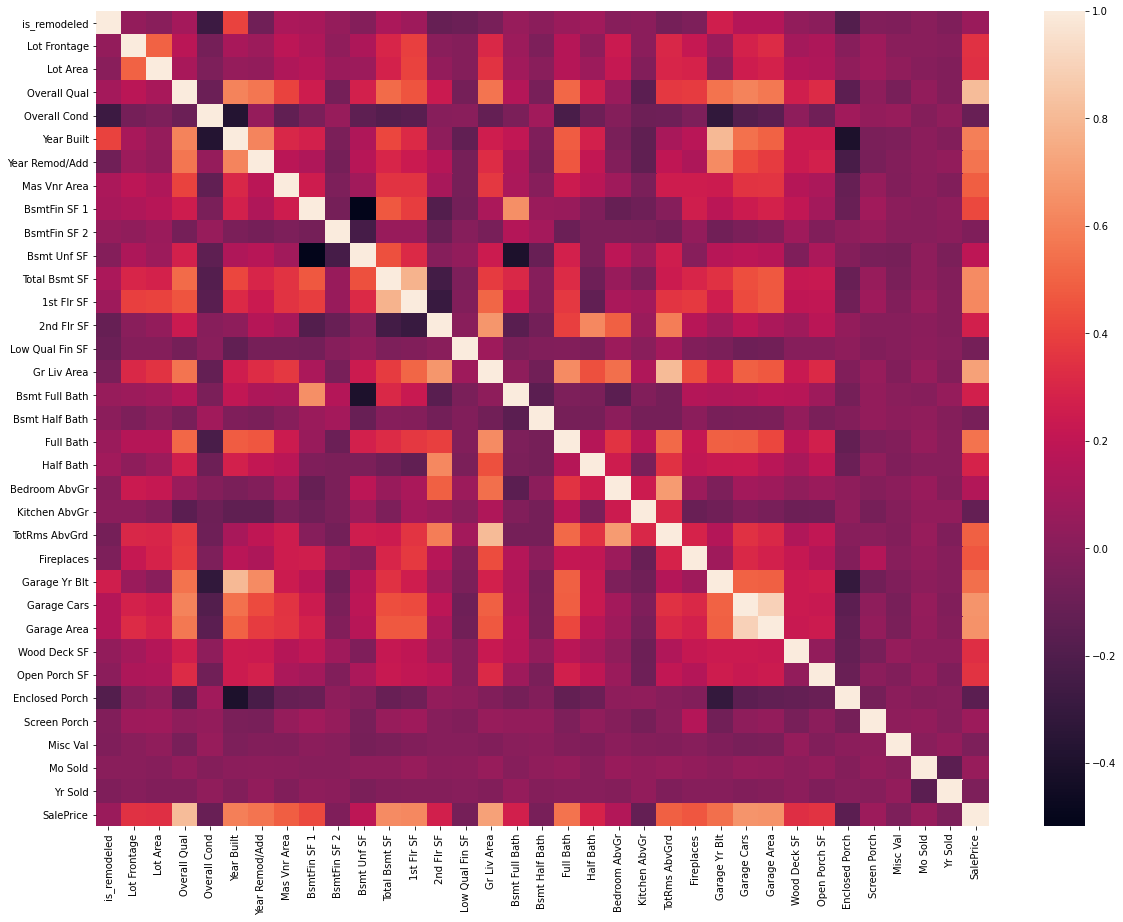

In [7]:
fig, ax = plt.subplots(figsize=(20, 15))

x = sns.heatmap(num_feats.corr(), ax=ax)

We can see that features 'Total Bsmt SF' and '1st Floor SF' are closely related, and from the description of the dataset it seems only logical. Let's focus on them

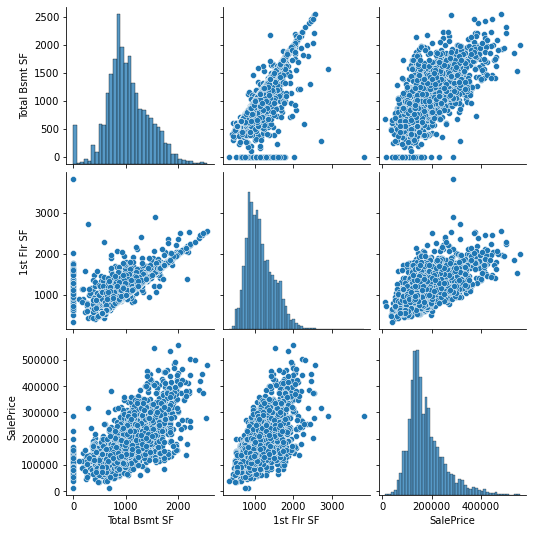

In [8]:
sns.pairplot(num_feats.loc[:, ['Total Bsmt SF', '1st Flr SF', 'SalePrice']])

We observe outliers with zero value for 'Total Bsmt SF'. Let's check corrplot for this data.

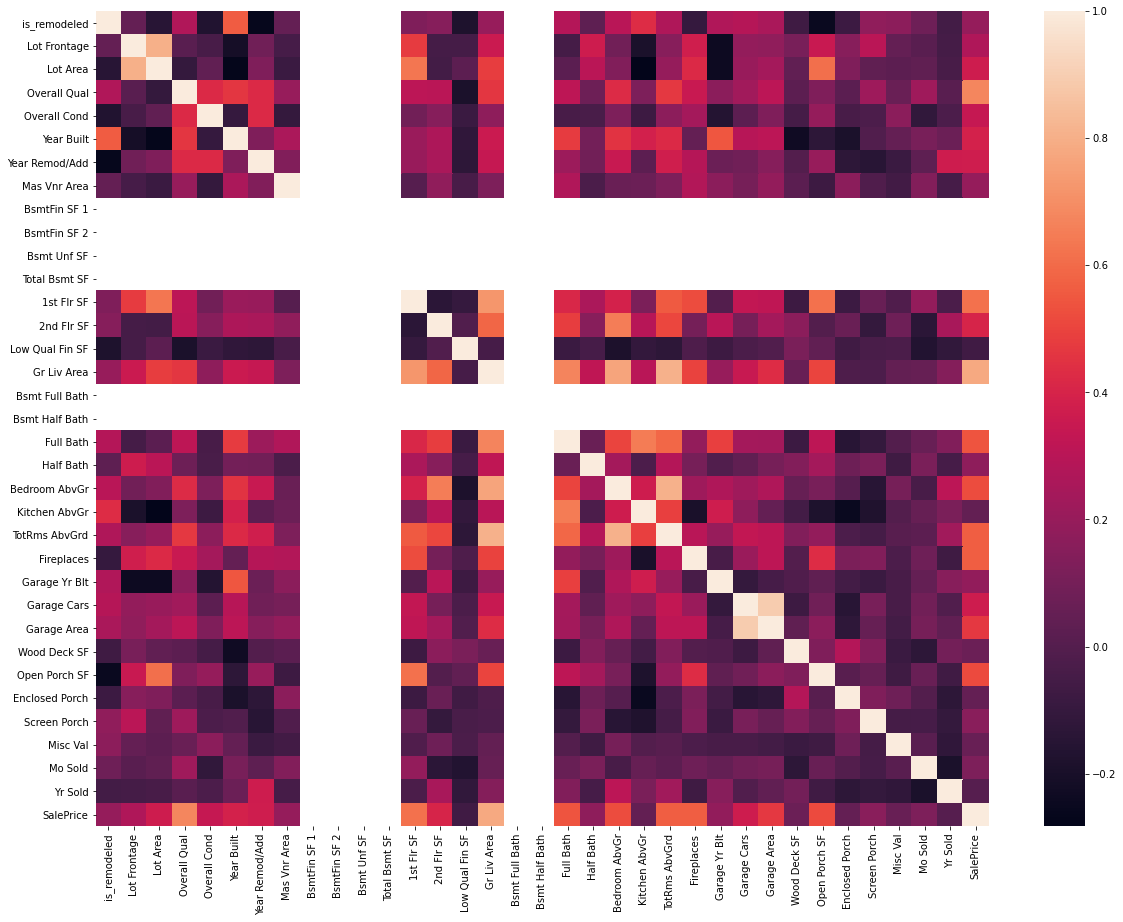

In [9]:
fig, ax = plt.subplots(figsize=(20, 15))

x = sns.heatmap(num_feats[num_feats['Total Bsmt SF'] == 0].corr(), ax=ax)

This corrplot along with description of dataset suggests us to inspect relation between features 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF' and feature 'Total Bsmt SF'. It looks like the sum of the first three may equal last. Let's check if it's true for whole dataset.

In [10]:
sum_of_bsmt = num_feats.loc[:, ['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF']].sum(axis=1)
(num_feats['Total Bsmt SF'] == sum_of_bsmt).all()

True

Our guess was right. So, looking on a heatmap, we can see that 'Total Bsmt SF' has higher correlation with target variable than other three so it would be good to drop them

In [11]:
num_feats.drop(['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF'], axis=1, inplace=True)

This leads us to idea that there could be other features connected in a similar way, let's check '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF' and 'Gr Liv Area'.

In [12]:
sum_of_bsmt = num_feats.loc[:, ['1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF']].sum(axis=1)
(num_feats['Gr Liv Area'] == sum_of_bsmt).all()

True

We observe the same situation here, let's drop excess features.

In [13]:
num_feats.drop(['1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF'], axis=1, inplace=True)

Let's check if relationship between remaining two features is good.

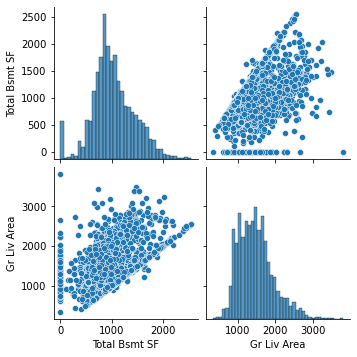

In [14]:
sns.pairplot(num_feats.loc[:, ['Total Bsmt SF', 'Gr Liv Area']])

Probably better to do something with zero values in 'Total Bsmt SF'. For example, make dummy feature.

In [15]:
num_feats['bsmt_not_zero'] = (num_feats['Total Bsmt SF'] > 0).astype('int32')

Let's inspect Garage features

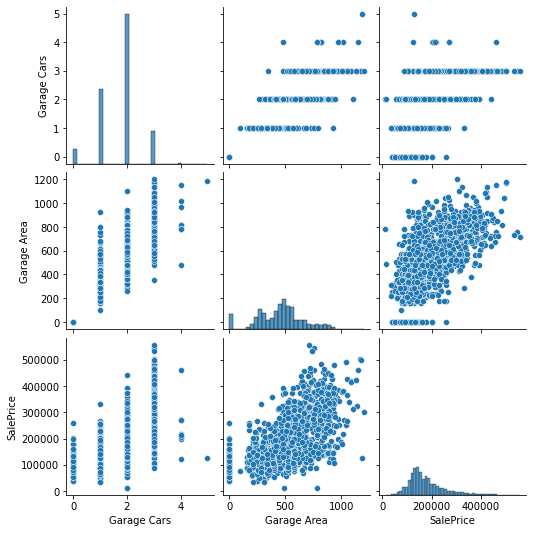

In [16]:
sns.pairplot(num_feats.loc[:, ['Garage Cars', 'Garage Area', 'SalePrice']]);

Probably better to make dummy for whether there is garage and drop 'Garage Cars' because this feature contains less information than continuous feature 'Garage Area' while having the same correlation with target variable.

In [17]:
num_feats.drop(['Garage Cars'], axis=1, inplace=True)
num_feats['has_garage'] = (num_feats['Garage Area'] > 0).astype('int32')

It looks reasonable to check if total bath count correlates with target variable better than separate counts.

In [18]:
num_feats.loc[:, ['Bsmt Full Bath', 'Full Bath', 'Bsmt Half Bath', 'Half Bath']].sum(axis=1).corr(num_feats['SalePrice'])

0.6188677556501196

Even taking into account 'Bsmt Half Bath' correlation with target variable, it sounds good and reasonable to sum it with others

In [19]:
num_feats['Bathrooms'] = num_feats.loc[:, ['Bsmt Full Bath', 'Full Bath', 'Bsmt Half Bath', 'Half Bath']].sum(axis=1)
num_feats.drop(['Bsmt Full Bath', 'Full Bath', 'Bsmt Half Bath', 'Half Bath'], axis=1, inplace=True)

Let's inspect relationship between 'AbvGr' features and 'Gr Liv Area' as they should be strongly connected

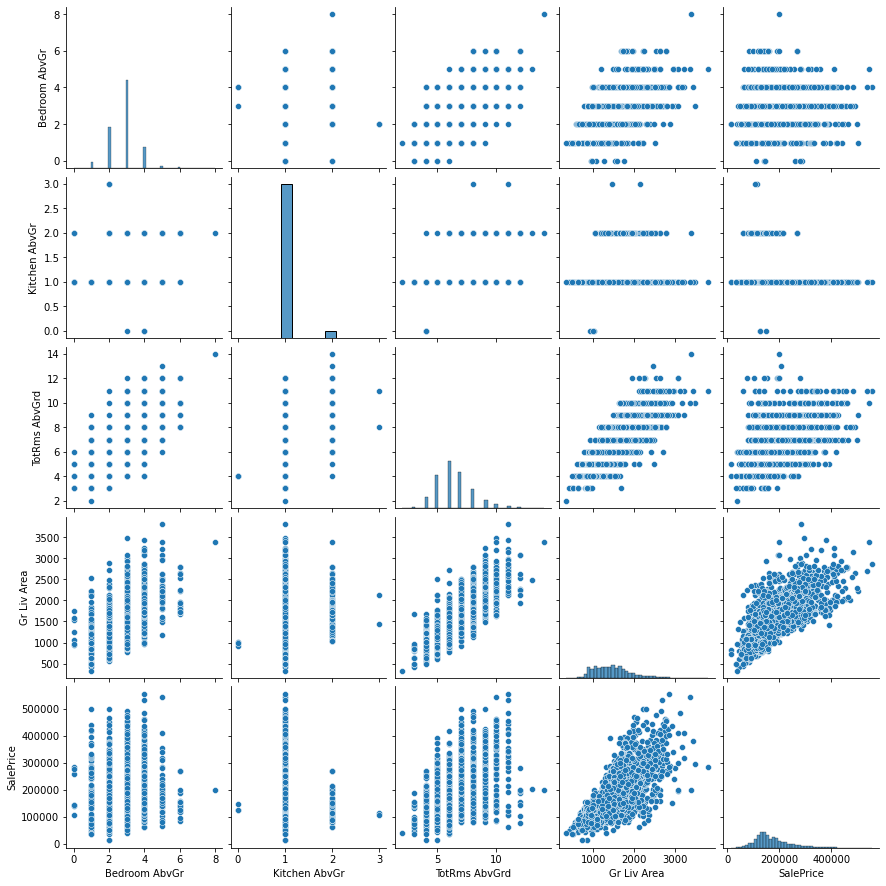

In [20]:
sns.pairplot(num_feats.loc[:, ['Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Gr Liv Area', 'SalePrice']]);

We could see that kitchen should probably be left as separate feature, but we could drop 'Totrms' and 'Bedroom' since the former is strongly correlated with 'Gr Liv Area' but have lower correlation with target and the latter seems not very discriptive while having high correlation with 'Gr Liv Area'

In [21]:
num_feats.drop(['Bedroom AbvGr', 'TotRms AbvGrd'], axis=1, inplace=True)

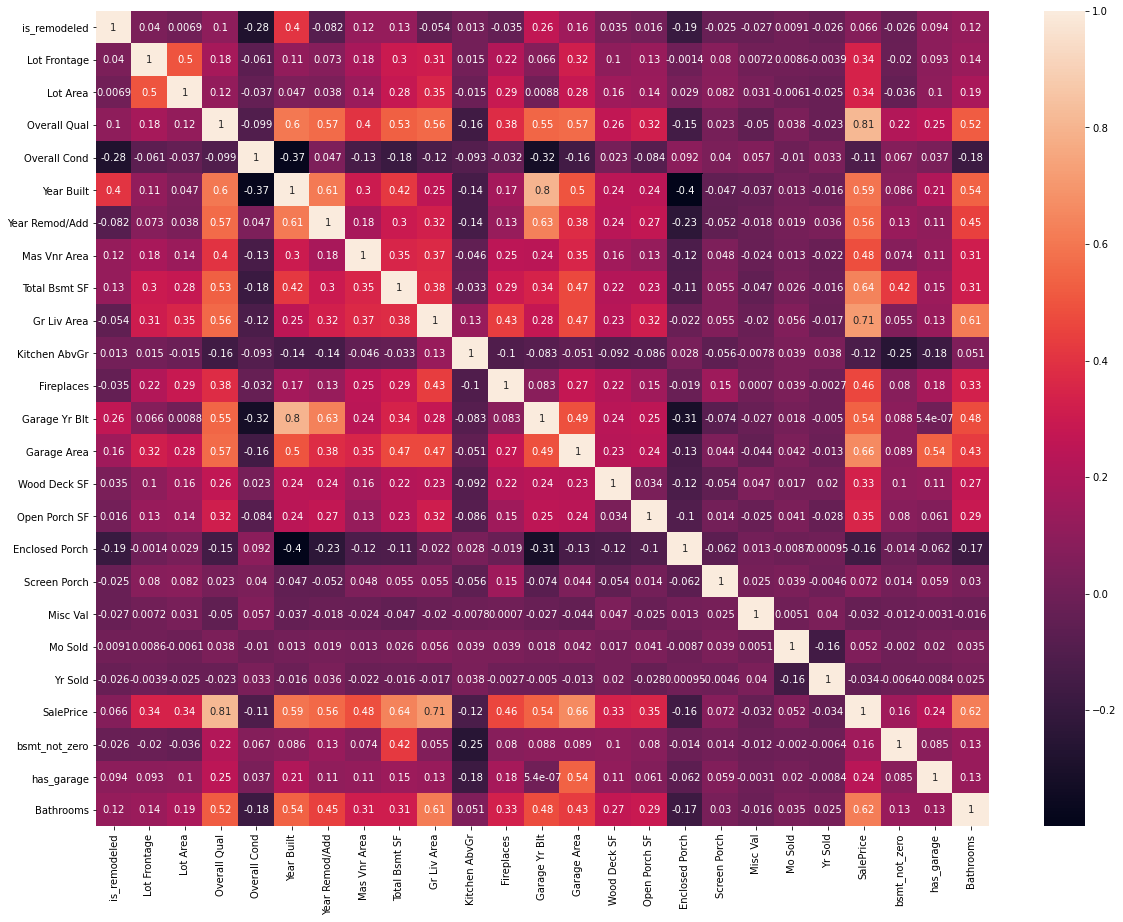

In [22]:
fig, ax = plt.subplots(figsize=(20, 15))

x = sns.heatmap(num_feats.corr(), ax=ax, annot=True)

Now let's deal with date features

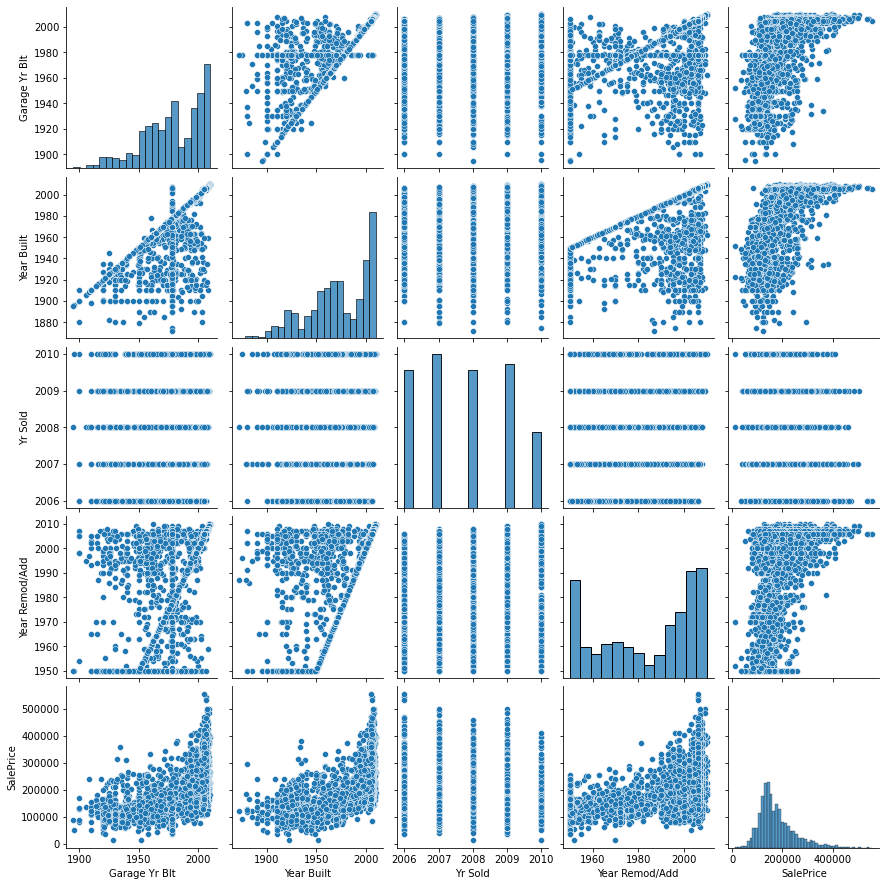

In [23]:
sns.pairplot(num_feats[['Garage Yr Blt', 'Year Built', 'Yr Sold', 'Year Remod/Add', 'SalePrice']]);

From the description of dataset we could propose three additional features - age of house, if house has been remodeled and time passed since it has been remodeled.

In [24]:
num_feats['is_remodeled'] = (num_feats['Year Built'] == num_feats['Year Remod/Add']).astype('int32')
num_feats['Age'] = num_feats['Yr Sold'] - num_feats['Year Built']
num_feats['Garage Age'] = num_feats['Yr Sold'] - num_feats['Garage Yr Blt']
num_feats['Since Remodeling'] = num_feats['Yr Sold'] - num_feats['Year Remod/Add']

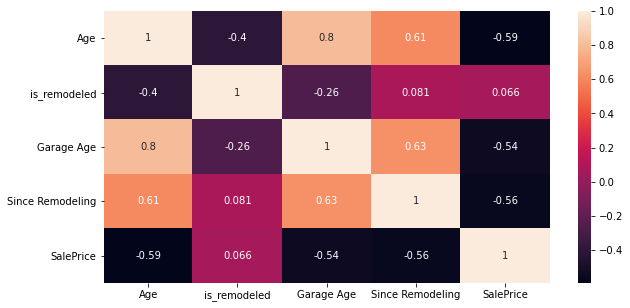

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))

x = sns.heatmap(num_feats[['Age', 'is_remodeled', 'Garage Age', 'Since Remodeling', 'SalePrice']].corr(), 
                ax=ax, annot=True)

We observe that 'is_remodeled' feature turns out to be not quite good but it has meaning and is not so heavily correlated as other three. So let's leave it and drop 'GarageAge'. Since 'Since Remodelling' appear to be good feature, let's decide whether to keep it or 'Age' after inspecting their correlations with other features

In [26]:
num_feats.drop('Garage Age', axis=1, inplace=True)

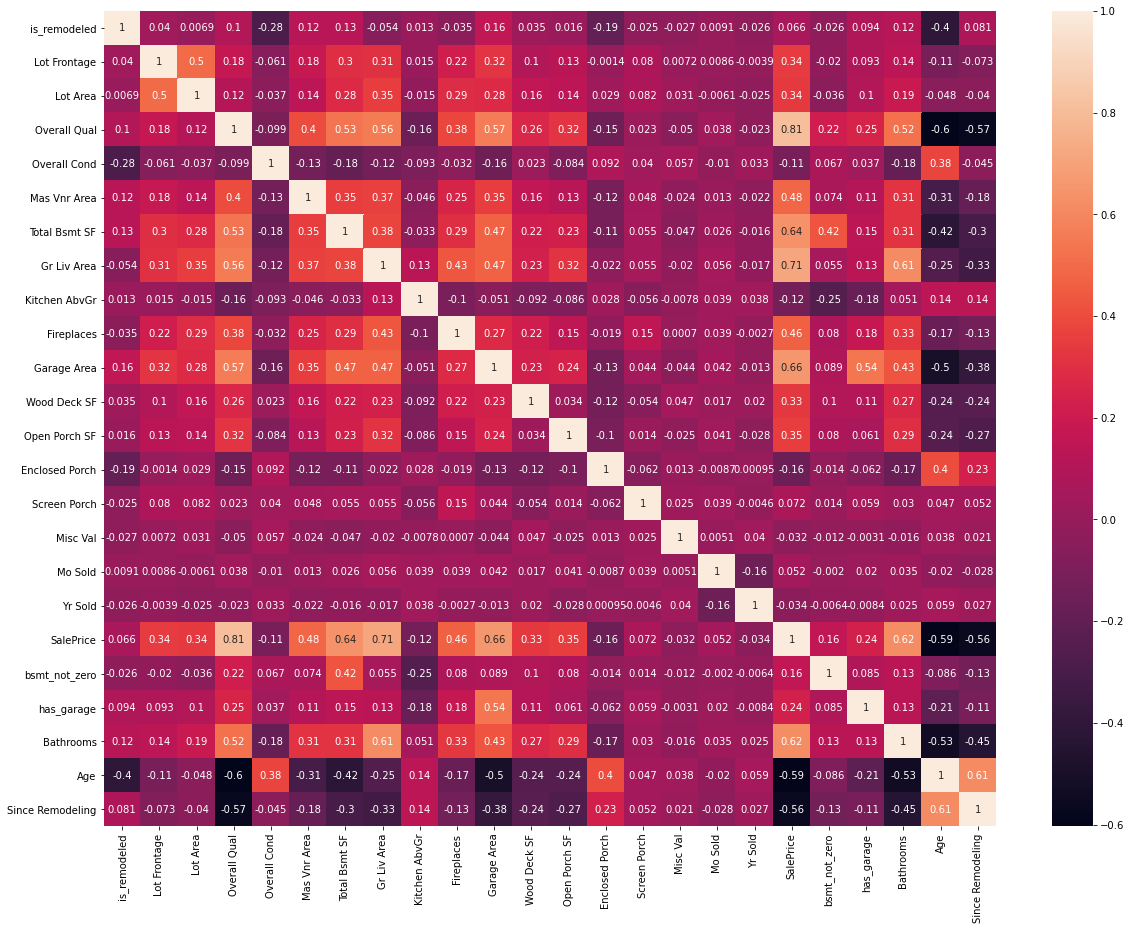

In [27]:
fig, ax = plt.subplots(figsize=(20, 15))

x = sns.heatmap(num_feats.drop(['Year Built', 'Garage Yr Blt', 'Year Remod/Add'], axis=1).corr(), 
                ax=ax, annot=True)

We observe that 'Since Remodelling' is slightly less correlated with other features, so we will keep it instead of 'Age' and drop our base features.

In [28]:
num_feats.drop(['Age', 'Year Built', 'Garage Yr Blt', 'Year Remod/Add'], axis=1, inplace=True)

Let's also observe 'Mo Sold' feature.

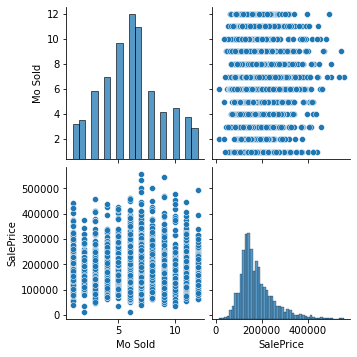

In [29]:
sns.pairplot(num_feats[['Mo Sold', 'SalePrice']])

It's only logical that there's no close relationship between these two variables. Maybe try new feature 'timeline'

In [30]:
min_yr = num_feats['Yr Sold'].min()
min_mo = num_feats[num_feats['Yr Sold'] == min_yr]['Mo Sold'].min()

num_feats['timeline'] = (num_feats['Yr Sold'] - min_yr)*12 + num_feats['Mo Sold'] - min_mo

Correlation:  -0.025889694511408712


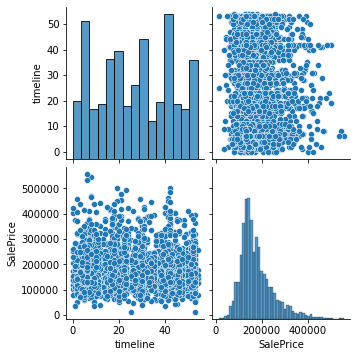

In [31]:
print('Correlation: ', num_feats['timeline'].corr(num_feats['SalePrice']))
sns.pairplot(num_feats[['timeline', 'SalePrice']]);

Correlation only worsens the situation so it's better to drop this variable

In [32]:
num_feats.drop(['timeline', 'Mo Sold'], axis=1, inplace=True)

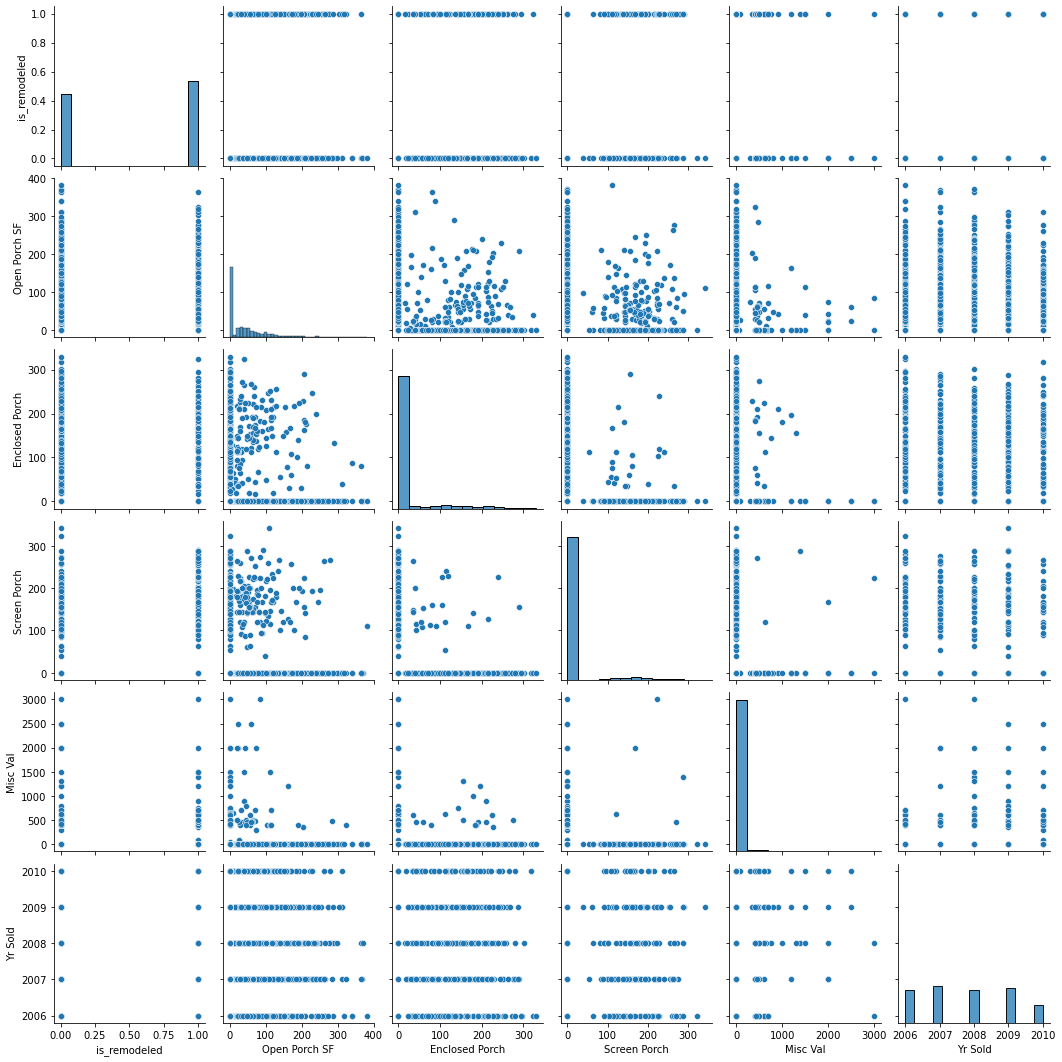

In [33]:
sns.pairplot(num_feats.iloc[:, [0, 12, 13, 14, 15, 16]]);

Now let's deal with categorical features

In [34]:
cat_feats = pd.concat([df.SalePrice.copy(), df.select_dtypes(include='string').copy()], axis=1)
cat_feats.columns

Index(['SalePrice', 'MS SubClass', 'MS Zoning', 'Street', 'Lot Shape',
       'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood',
       'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond',
       'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating',
       'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Fence', 'Sale Type', 'Sale Condition'],
      dtype='object')

From the description of the dataset we can see that there are many features which could probably be ordered. Let's take a look at them.

In [35]:
ordered_feats = ['Exter Qual', 'Exter Cond', 
                 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
                 'BsmtFin Type 1', 'BsmtFin Type 2',
                 'Heating QC', 'Kitchen Qual', 'Fireplace Qu',
                 'Functional', 'Garage Cond', 'Garage Qual',
                 'Garage Finish', 'Central Air', 'Paved Drive']
other_cat_feats = set(cat_feats.columns) - set(ordered_feats)
other_cat_feats.remove('SalePrice')

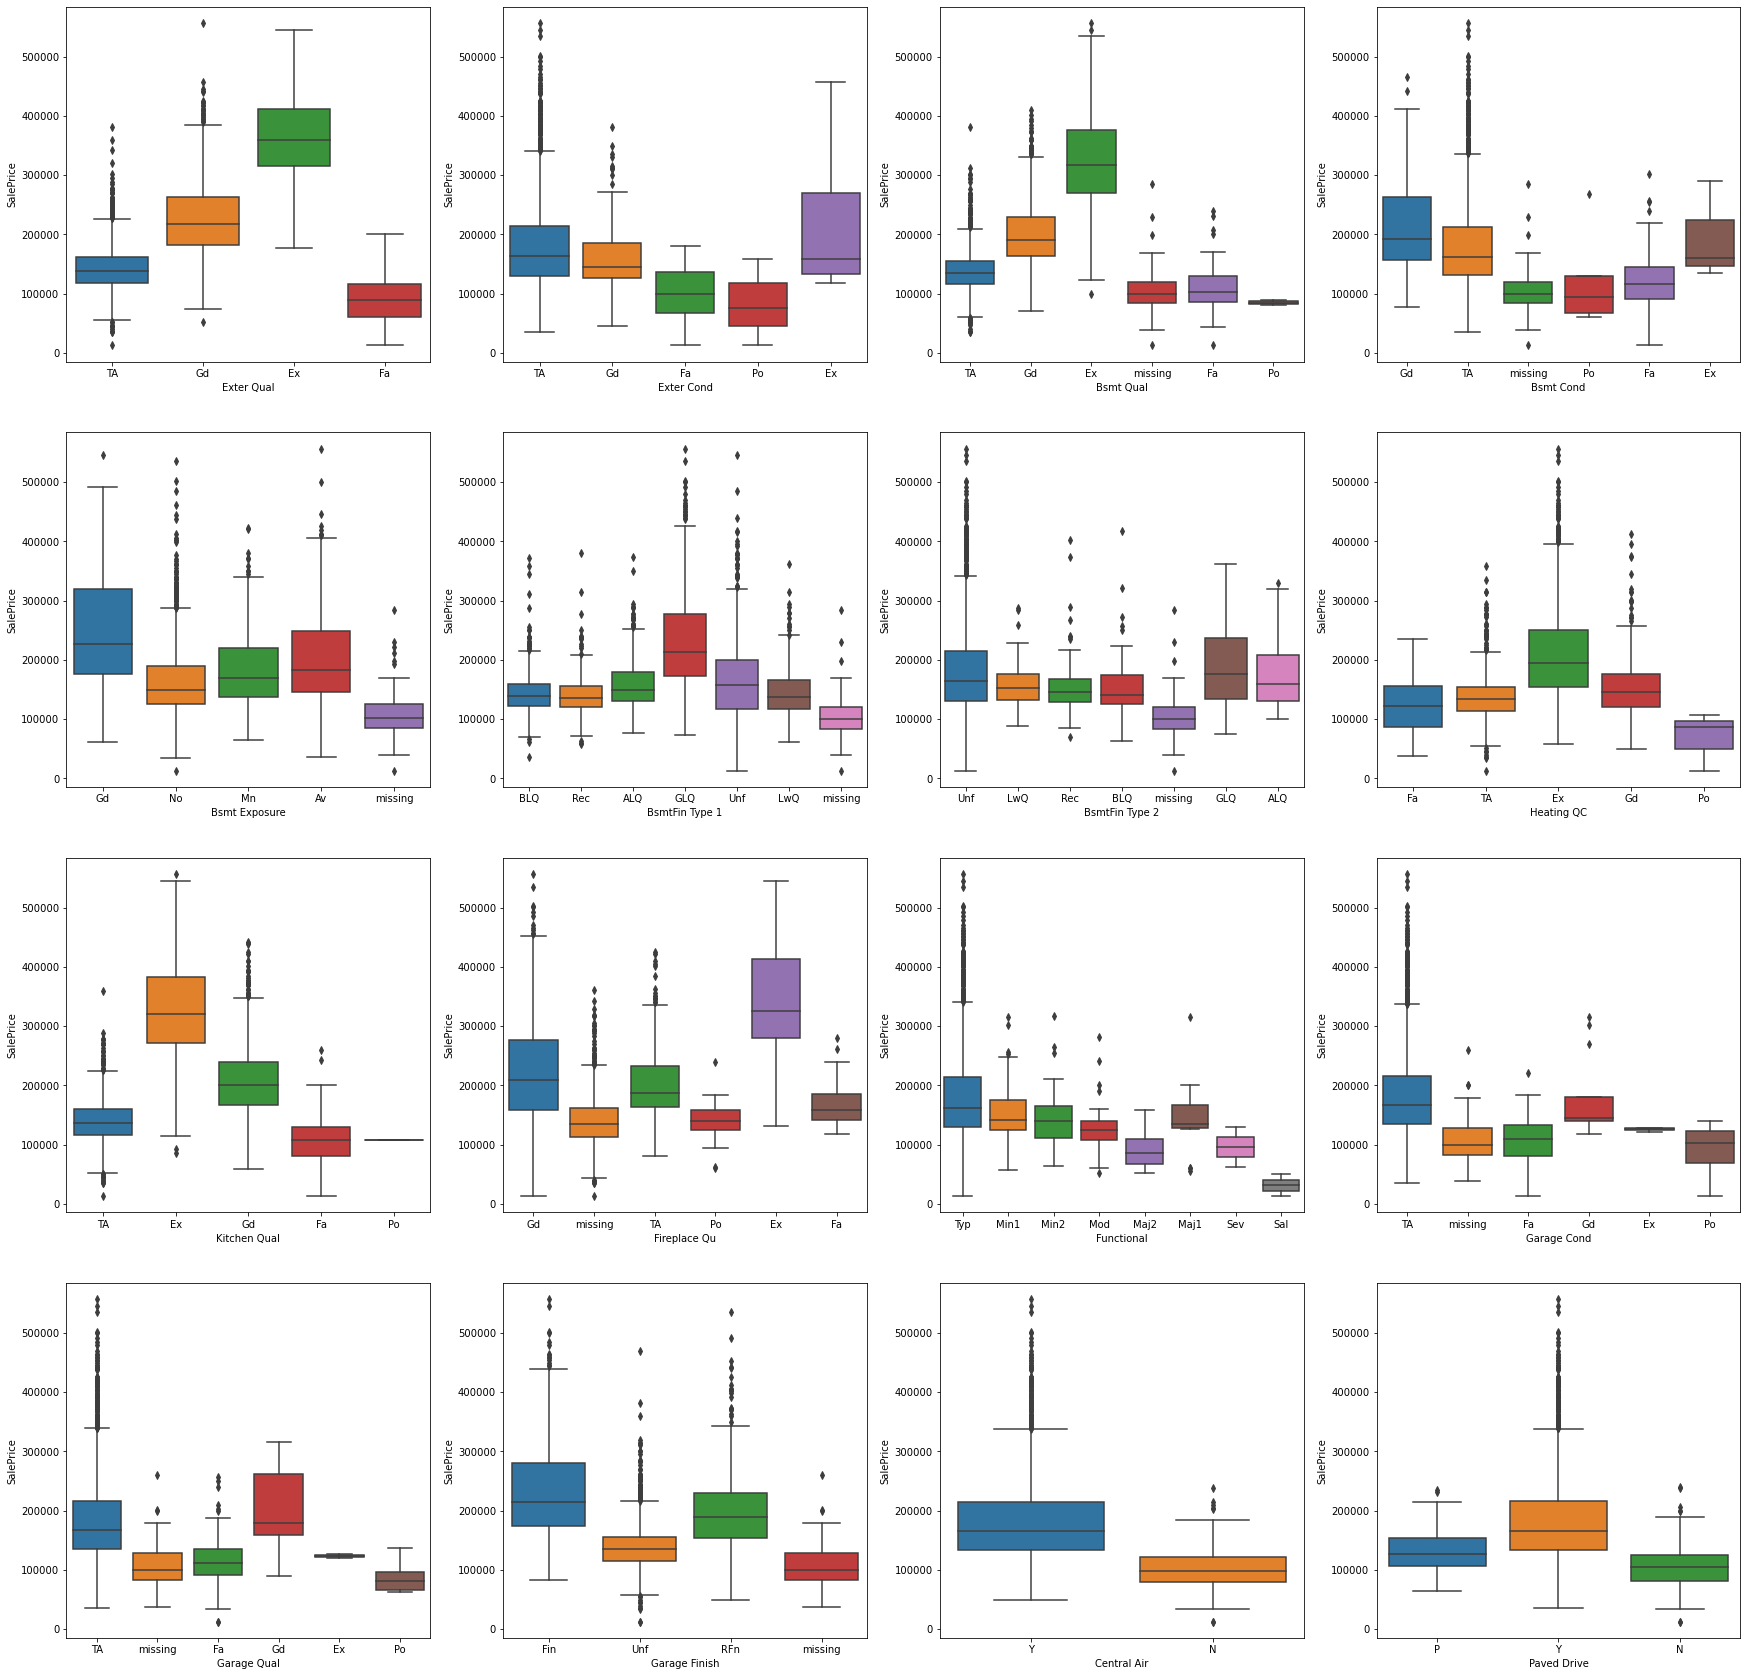

In [36]:
x = int(np.ceil(np.sqrt(len(ordered_feats))))
fig, axs = plt.subplots(x, x, figsize=(30,30))

for idx, col in enumerate(ordered_feats):
    sns.boxplot(x=col, y='SalePrice', data=cat_feats, ax=axs[idx//x, idx%x]);

From the looks of it, target variable in most cases should correlate with rank of categorical variable, should we introduce it. Let's do it and look at boxplots in according to value counts distribution and correlation matrix.

In [37]:
ranking = dict()
for feature in ordered_feats:
    ranking[feature] = cat_feats[[*ordered_feats, 'SalePrice']].groupby(by=feature)['SalePrice'].mean() \
                                    .sort_values().rank(method='first').to_dict()
    
for col, value in cat_feats[ordered_feats].iteritems():
    cat_feats[col] = value.map(ranking[col])
    cat_feats[col]

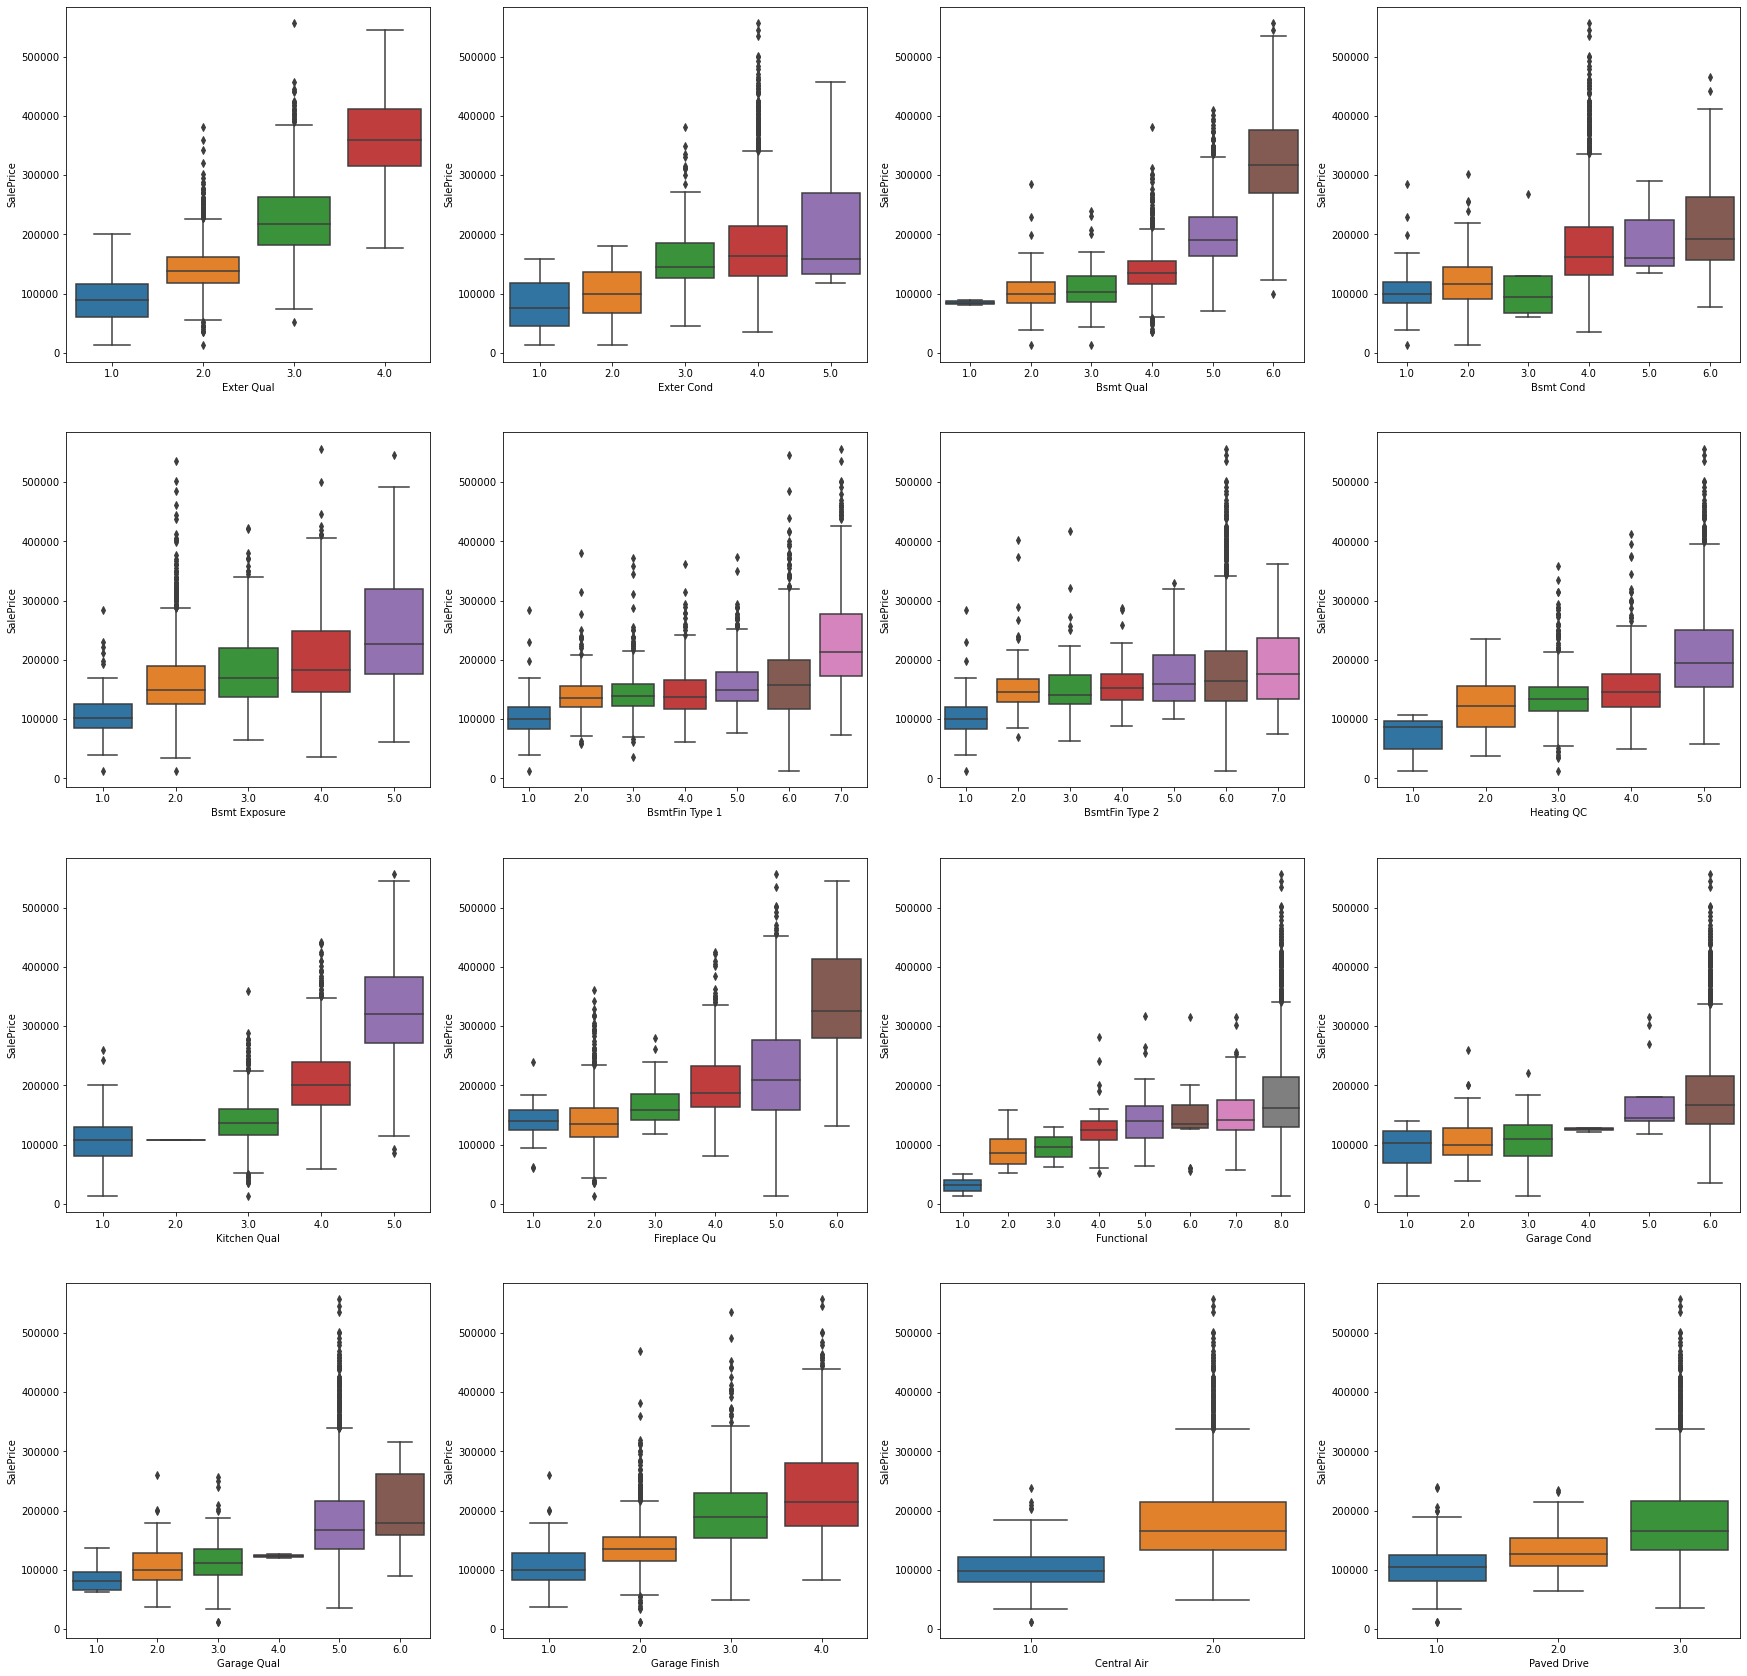

In [38]:
x = int(np.ceil(np.sqrt(len(ordered_feats))))
fig, axs = plt.subplots(x, x, figsize=(30,30))

for idx, col in enumerate(ordered_feats):
    sns.boxplot(x=col, y='SalePrice', data=cat_feats, ax=axs[idx//x, idx%x]);

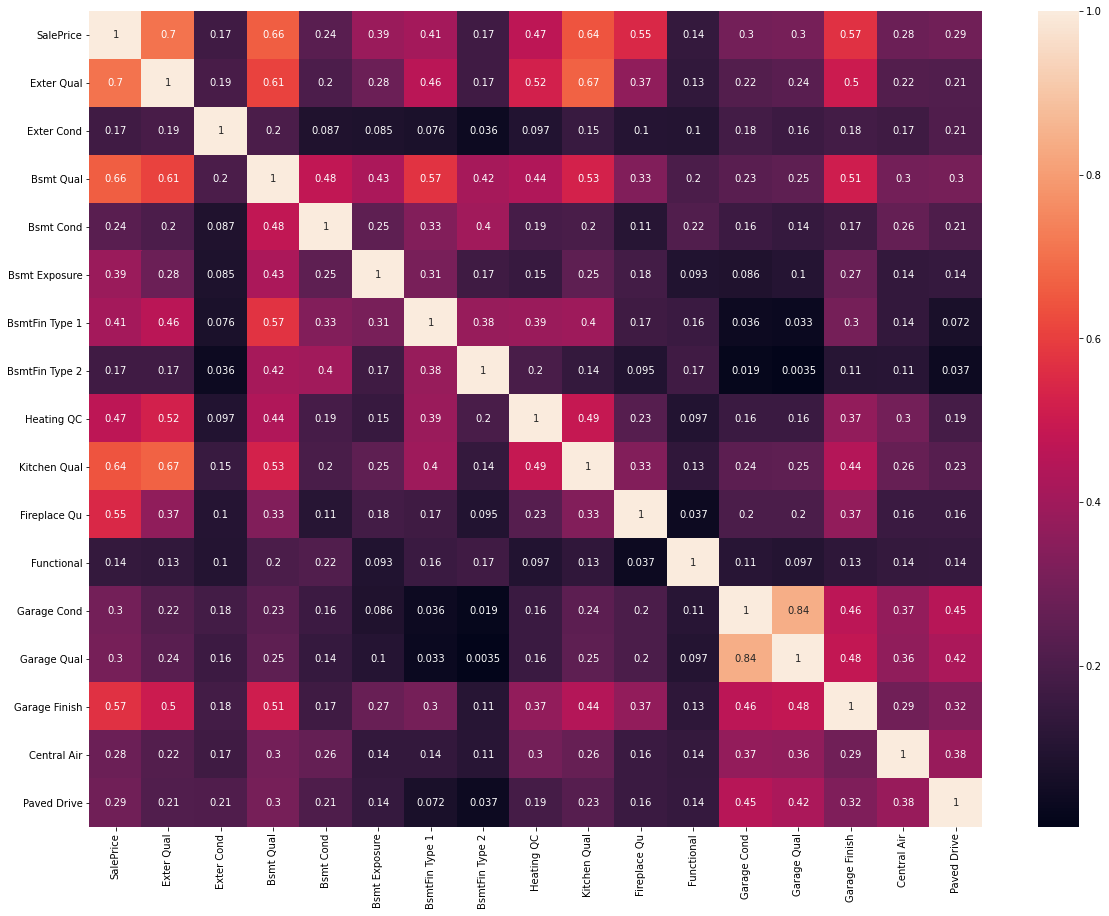

In [39]:
fig, ax = plt.subplots(figsize=(20, 15))

x = sns.heatmap(cat_feats[['SalePrice', *ordered_feats]].corr(), 
                ax=ax, annot=True)

In many cases we were probably right, but there are some features where relationship is not that obvious. We should probably rework them in some way

In [40]:
cat_feats['exter_con_dmy'] = (cat_feats['Exter Cond'] < 3).astype('int32')
cat_feats['bsmt_qual_dmy'] = (cat_feats['Bsmt Qual'] < 4).astype('int32')
cat_feats['bsmt_cond_dmy'] = (cat_feats['Bsmt Cond'] < 4).astype('int32')
cat_feats['bsmt_exposure_dmy'] = (cat_feats['Bsmt Exposure'] == 2).astype('int32')
cat_feats['bsmt_fin_1_dmy'] = (cat_feats['BsmtFin Type 1'] == 7).astype('int32')
cat_feats['bsmt_fin_2_dmy'] = (cat_feats['BsmtFin Type 2'] == 6).astype('int32')
cat_feats['fireplace_qu_dmy'] = (cat_feats['Fireplace Qu'].isin([1,3])).astype('int32')
cat_feats['functional_dmy'] = (cat_feats['Functional']== 8).astype('int32')
cat_feats['garage_cond_dmy'] = (cat_feats['Garage Cond']== 6).astype('int32')
cat_feats['garage_qual_dmy'] = (cat_feats['Garage Qual'] < 4).astype('int32')

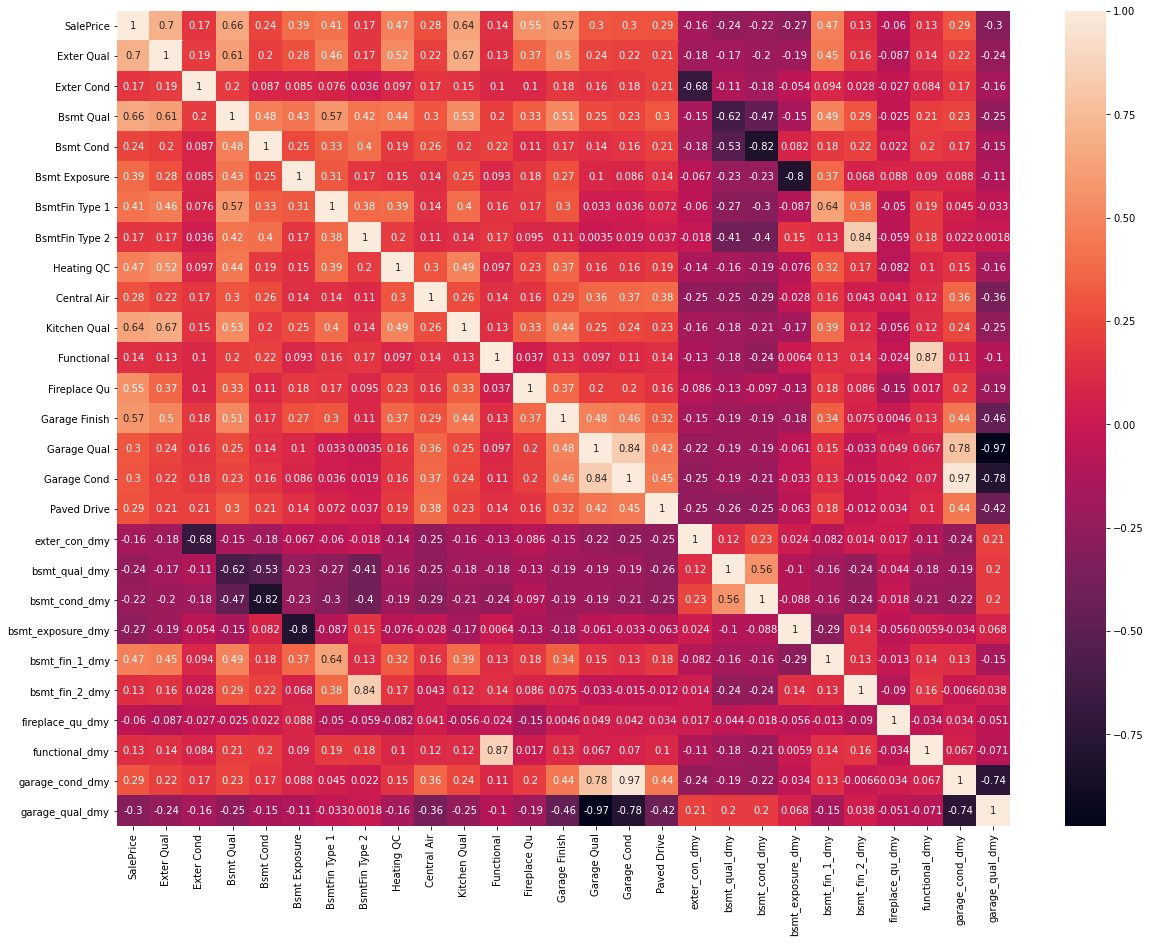

In [41]:
fig, ax = plt.subplots(figsize=(20, 15))

x = sns.heatmap(cat_feats.corr(), 
                ax=ax, annot=True)

In [42]:
cat_feats.drop(['Bsmt Cond', 'Garage Cond', 'Bsmt Qual', 
                'exter_con_dmy', 'bsmt_qual_dmy', 'bsmt_fin_1_dmy', 'garage_qual_dmy', 
                'functional_dmy', 'bsmt_exposure_dmy', 'bsmt_fin_2_dmy'], 
               axis=1, inplace=True)

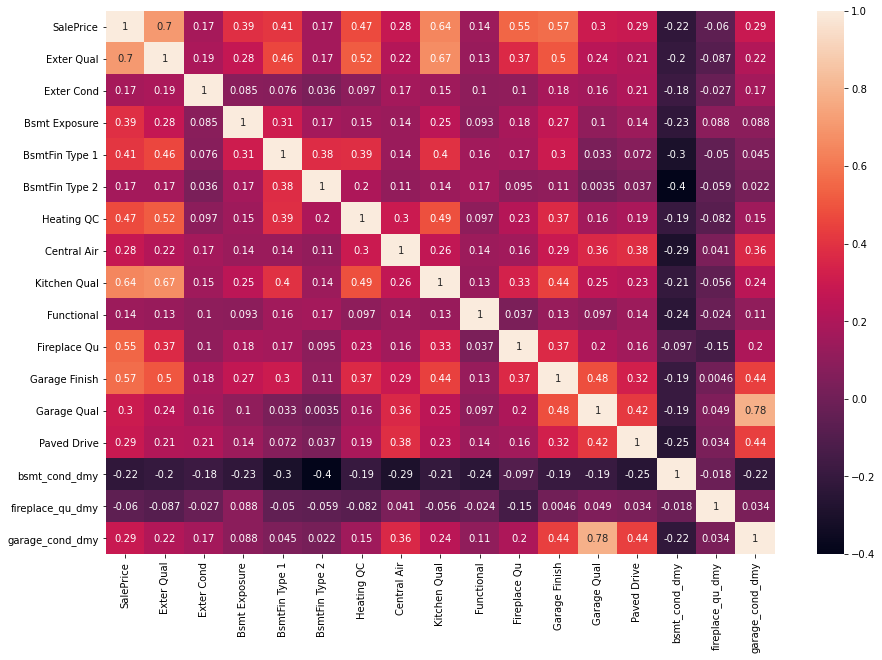

In [43]:
fig, ax = plt.subplots(figsize=(15, 10))

x = sns.heatmap(cat_feats.corr(), 
                ax=ax, annot=True)

Now let's look if these features correlate with original numerical features

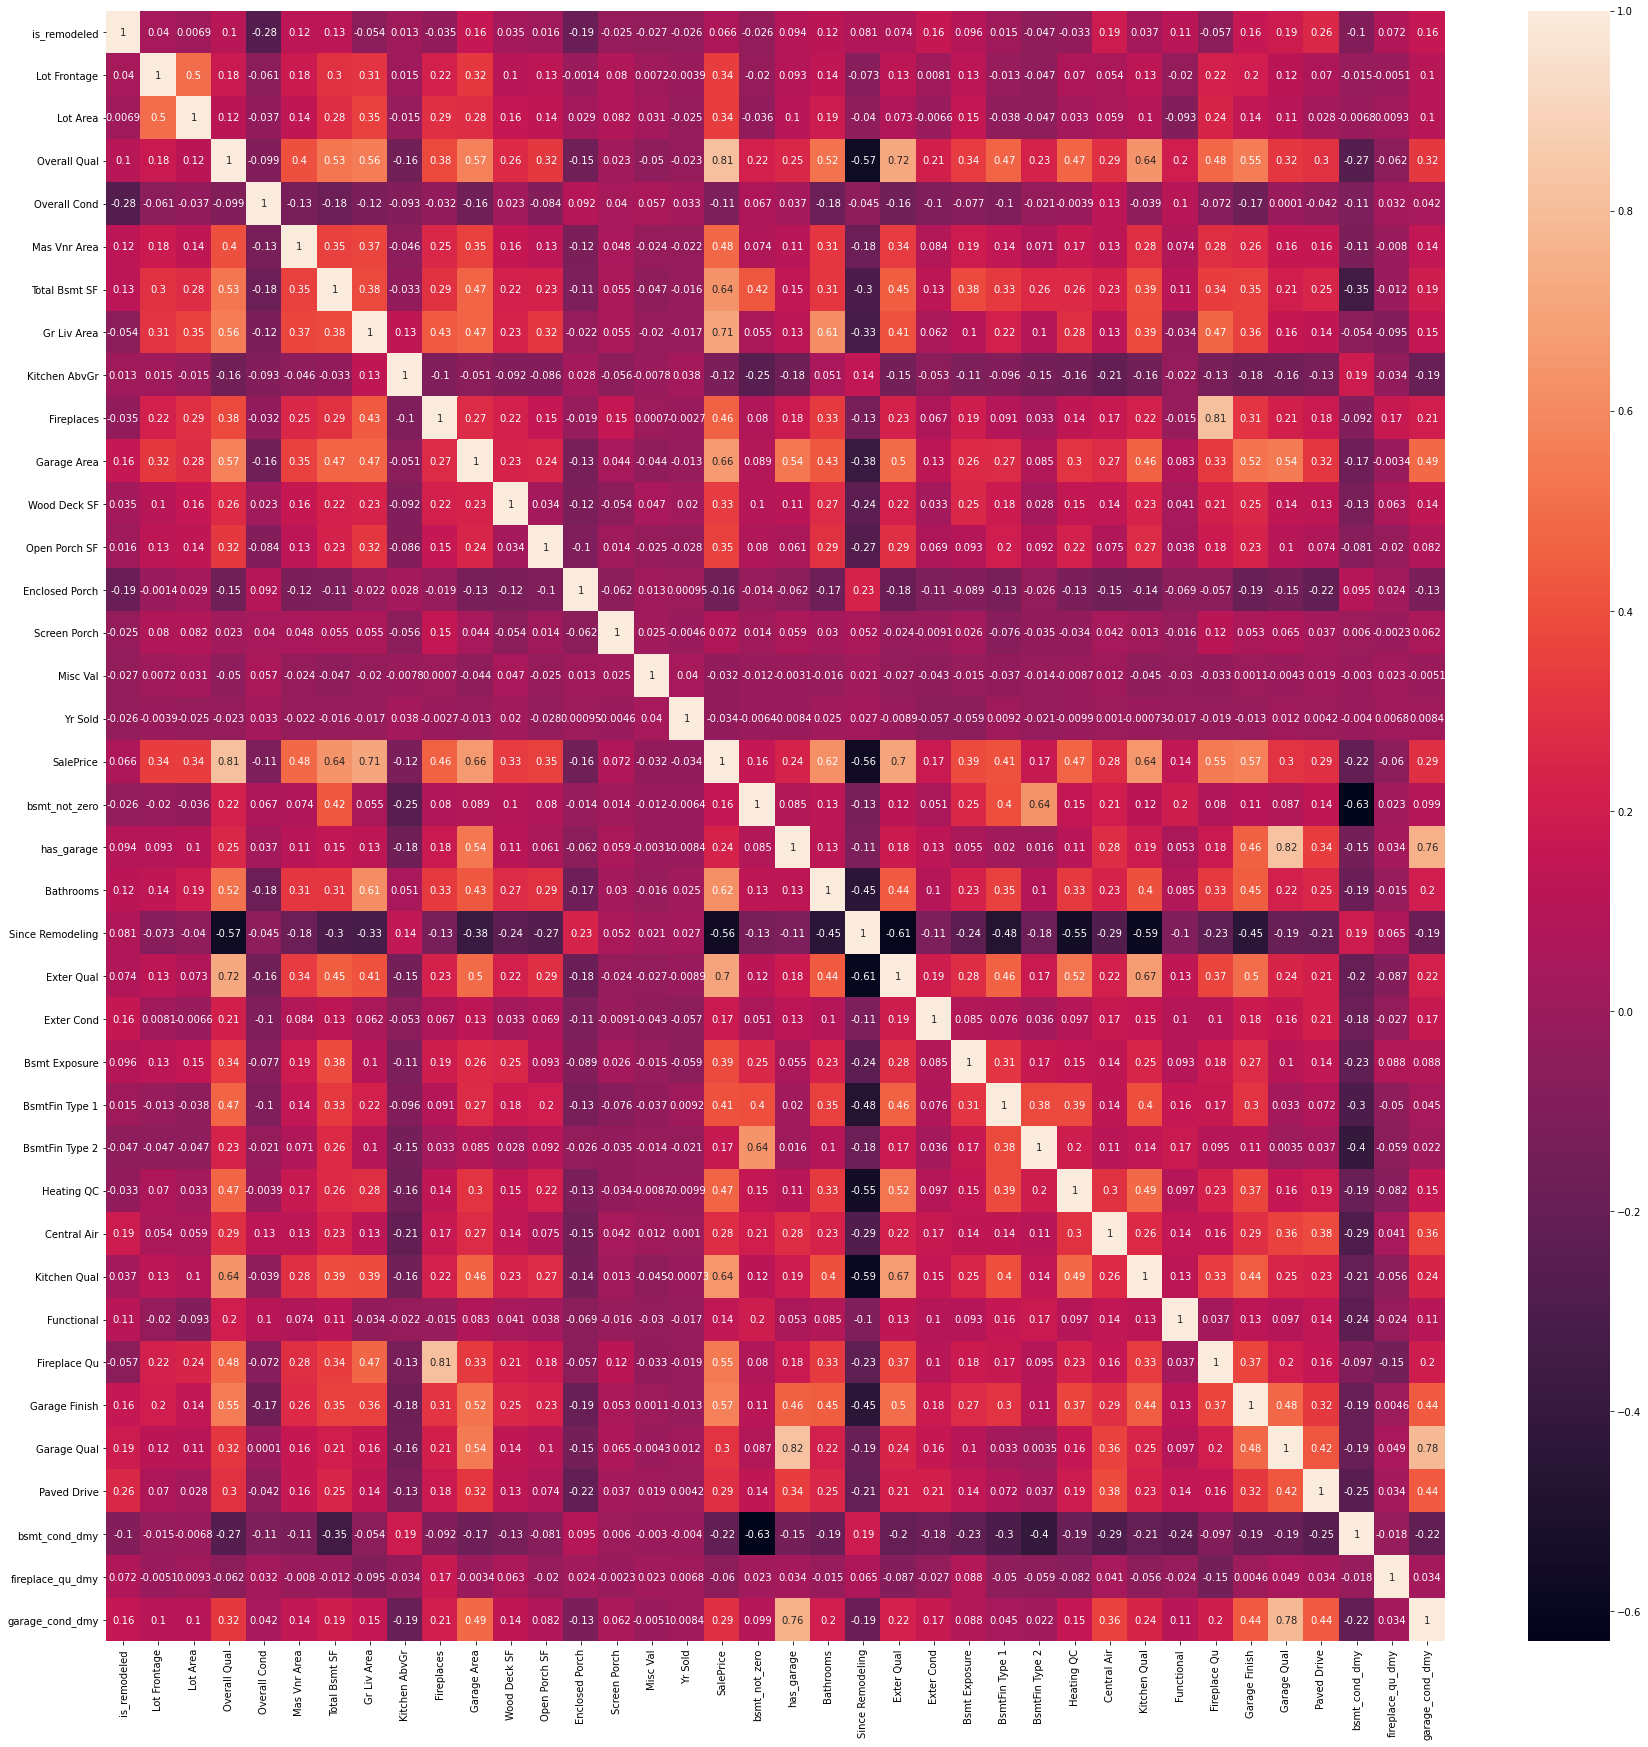

In [44]:
fig, ax = plt.subplots(figsize=(30, 30))

x = sns.heatmap(pd.concat([num_feats, cat_feats.iloc[:, 1:]], axis=1).corr(), 
                ax=ax, annot=True)

Based on this correlation matrix, the decision was made to drop 'Since Remodeling' (even though this feature sounds very good from common point of view, it is heavily correlated with lots of other features), 'has_garage', 'bsmt_not_zero', 'Fireplaces', 'Bathrooms' and 'Garage Finish' (all of these have similar features which have higher correlation with target variable)

In [45]:
num_feats.drop(['Fireplaces', 'has_garage', 'bsmt_not_zero', 
                'Since Remodeling', 'Bathrooms'], axis=1, inplace=True)
cat_feats.drop(['Garage Finish', 'Garage Qual'], axis=1, inplace=True)

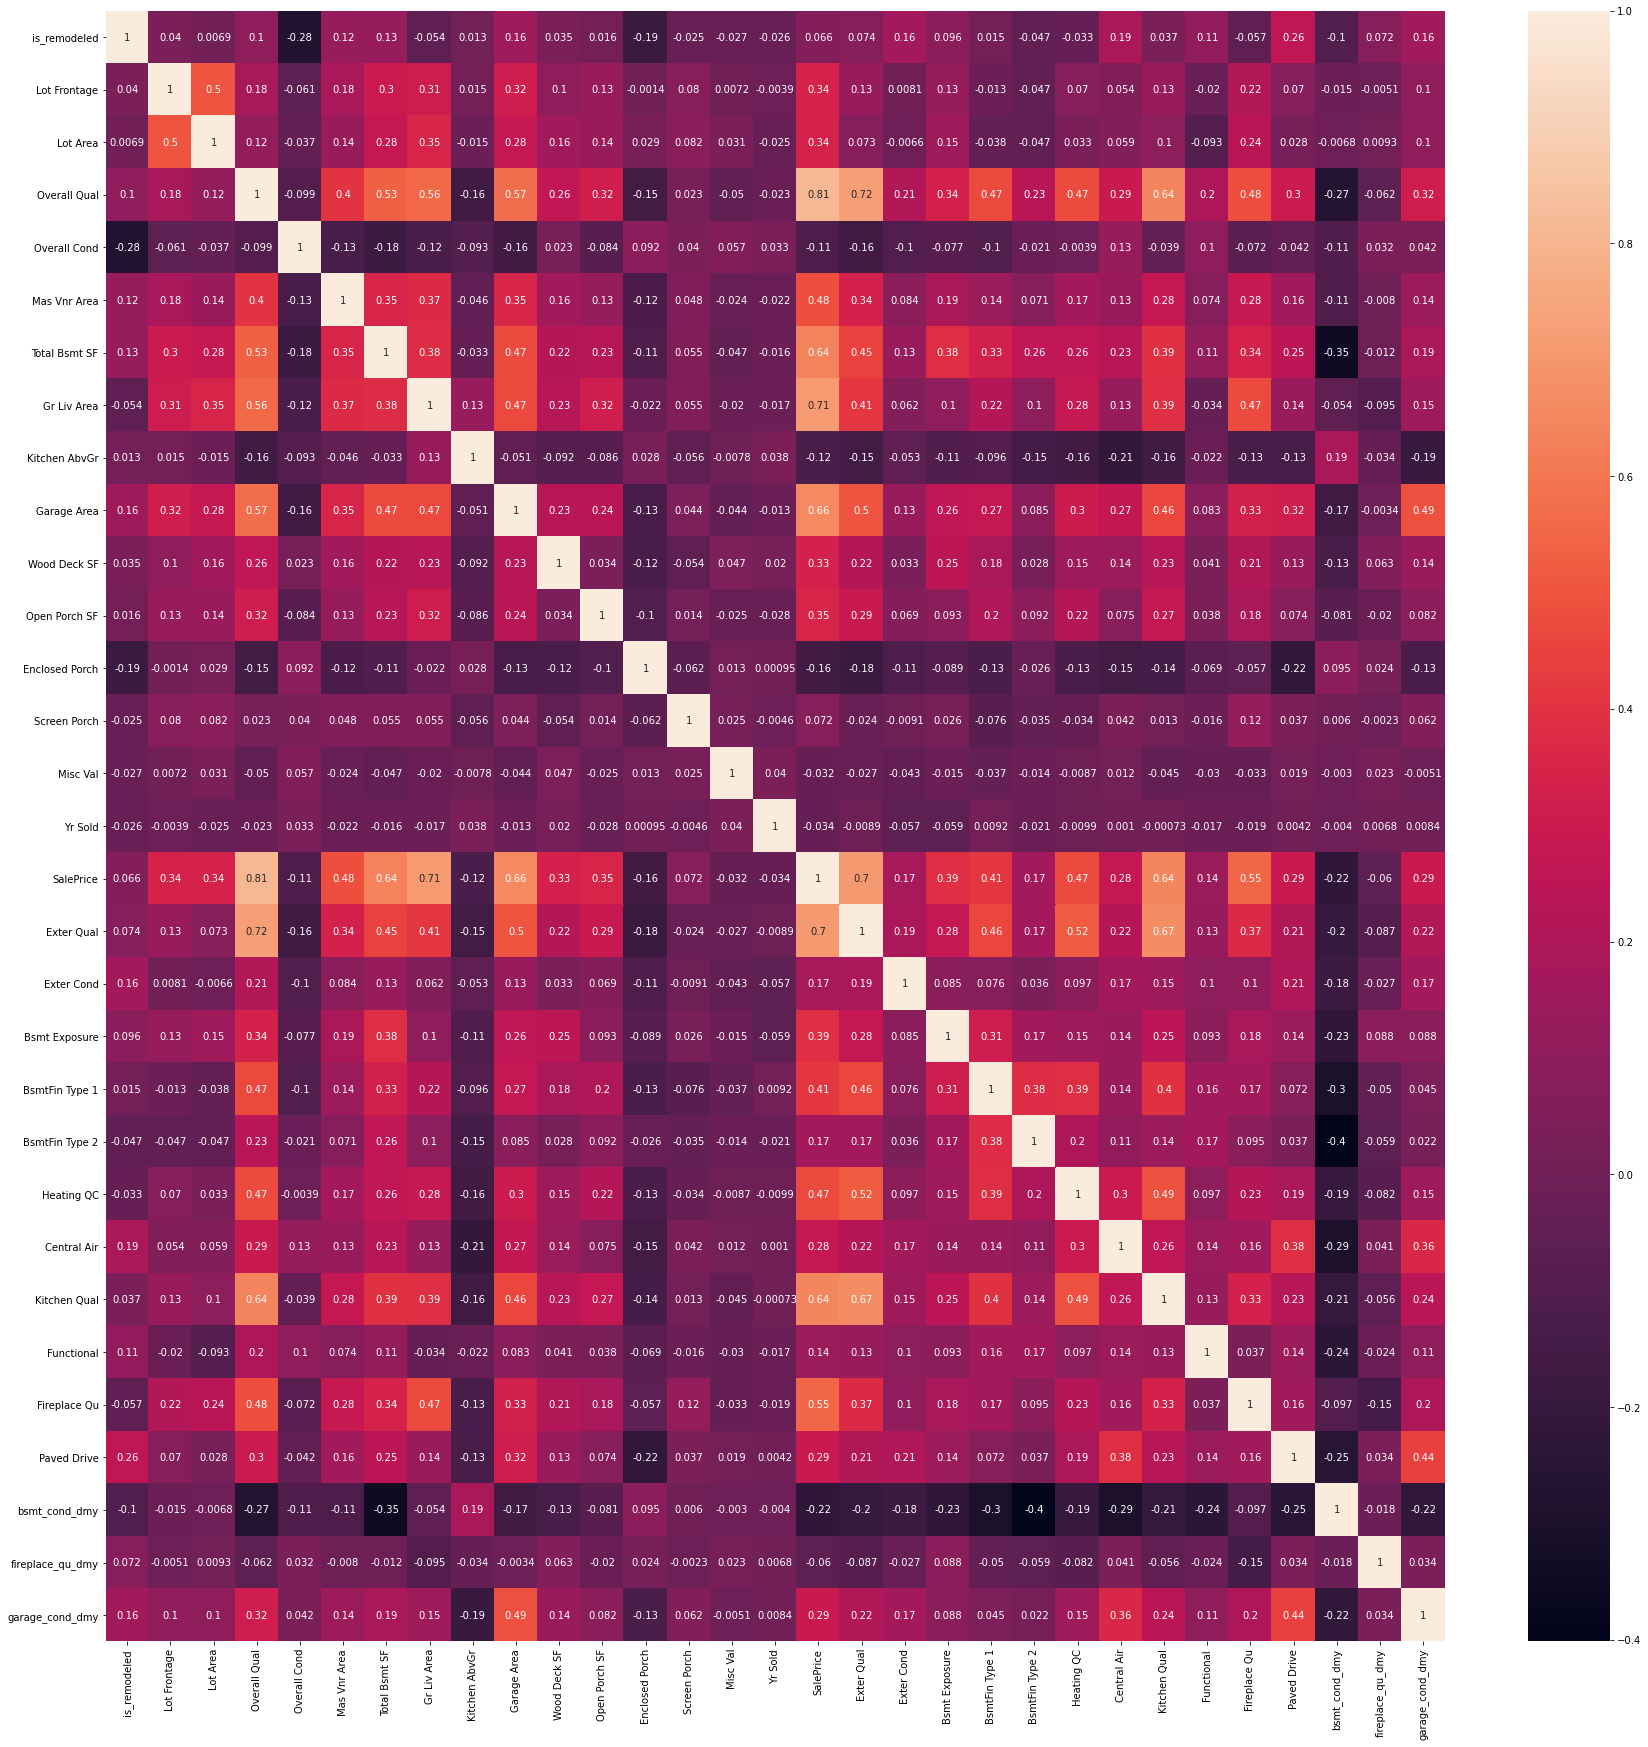

In [46]:
fig, ax = plt.subplots(figsize=(30, 30))

x = sns.heatmap(pd.concat([num_feats, cat_feats.iloc[:, 1:]], axis=1).corr(), 
                ax=ax, annot=True)

We have several features of similar nature, 'Overall Qual', 'Exter Qual' and 'Kitchen Qual', that are strongly correlated with the rest. It was decided to leave the decision, whether to drop it or not, until later.

Let's look at what we got left. This time, let's also check if there are any rare values

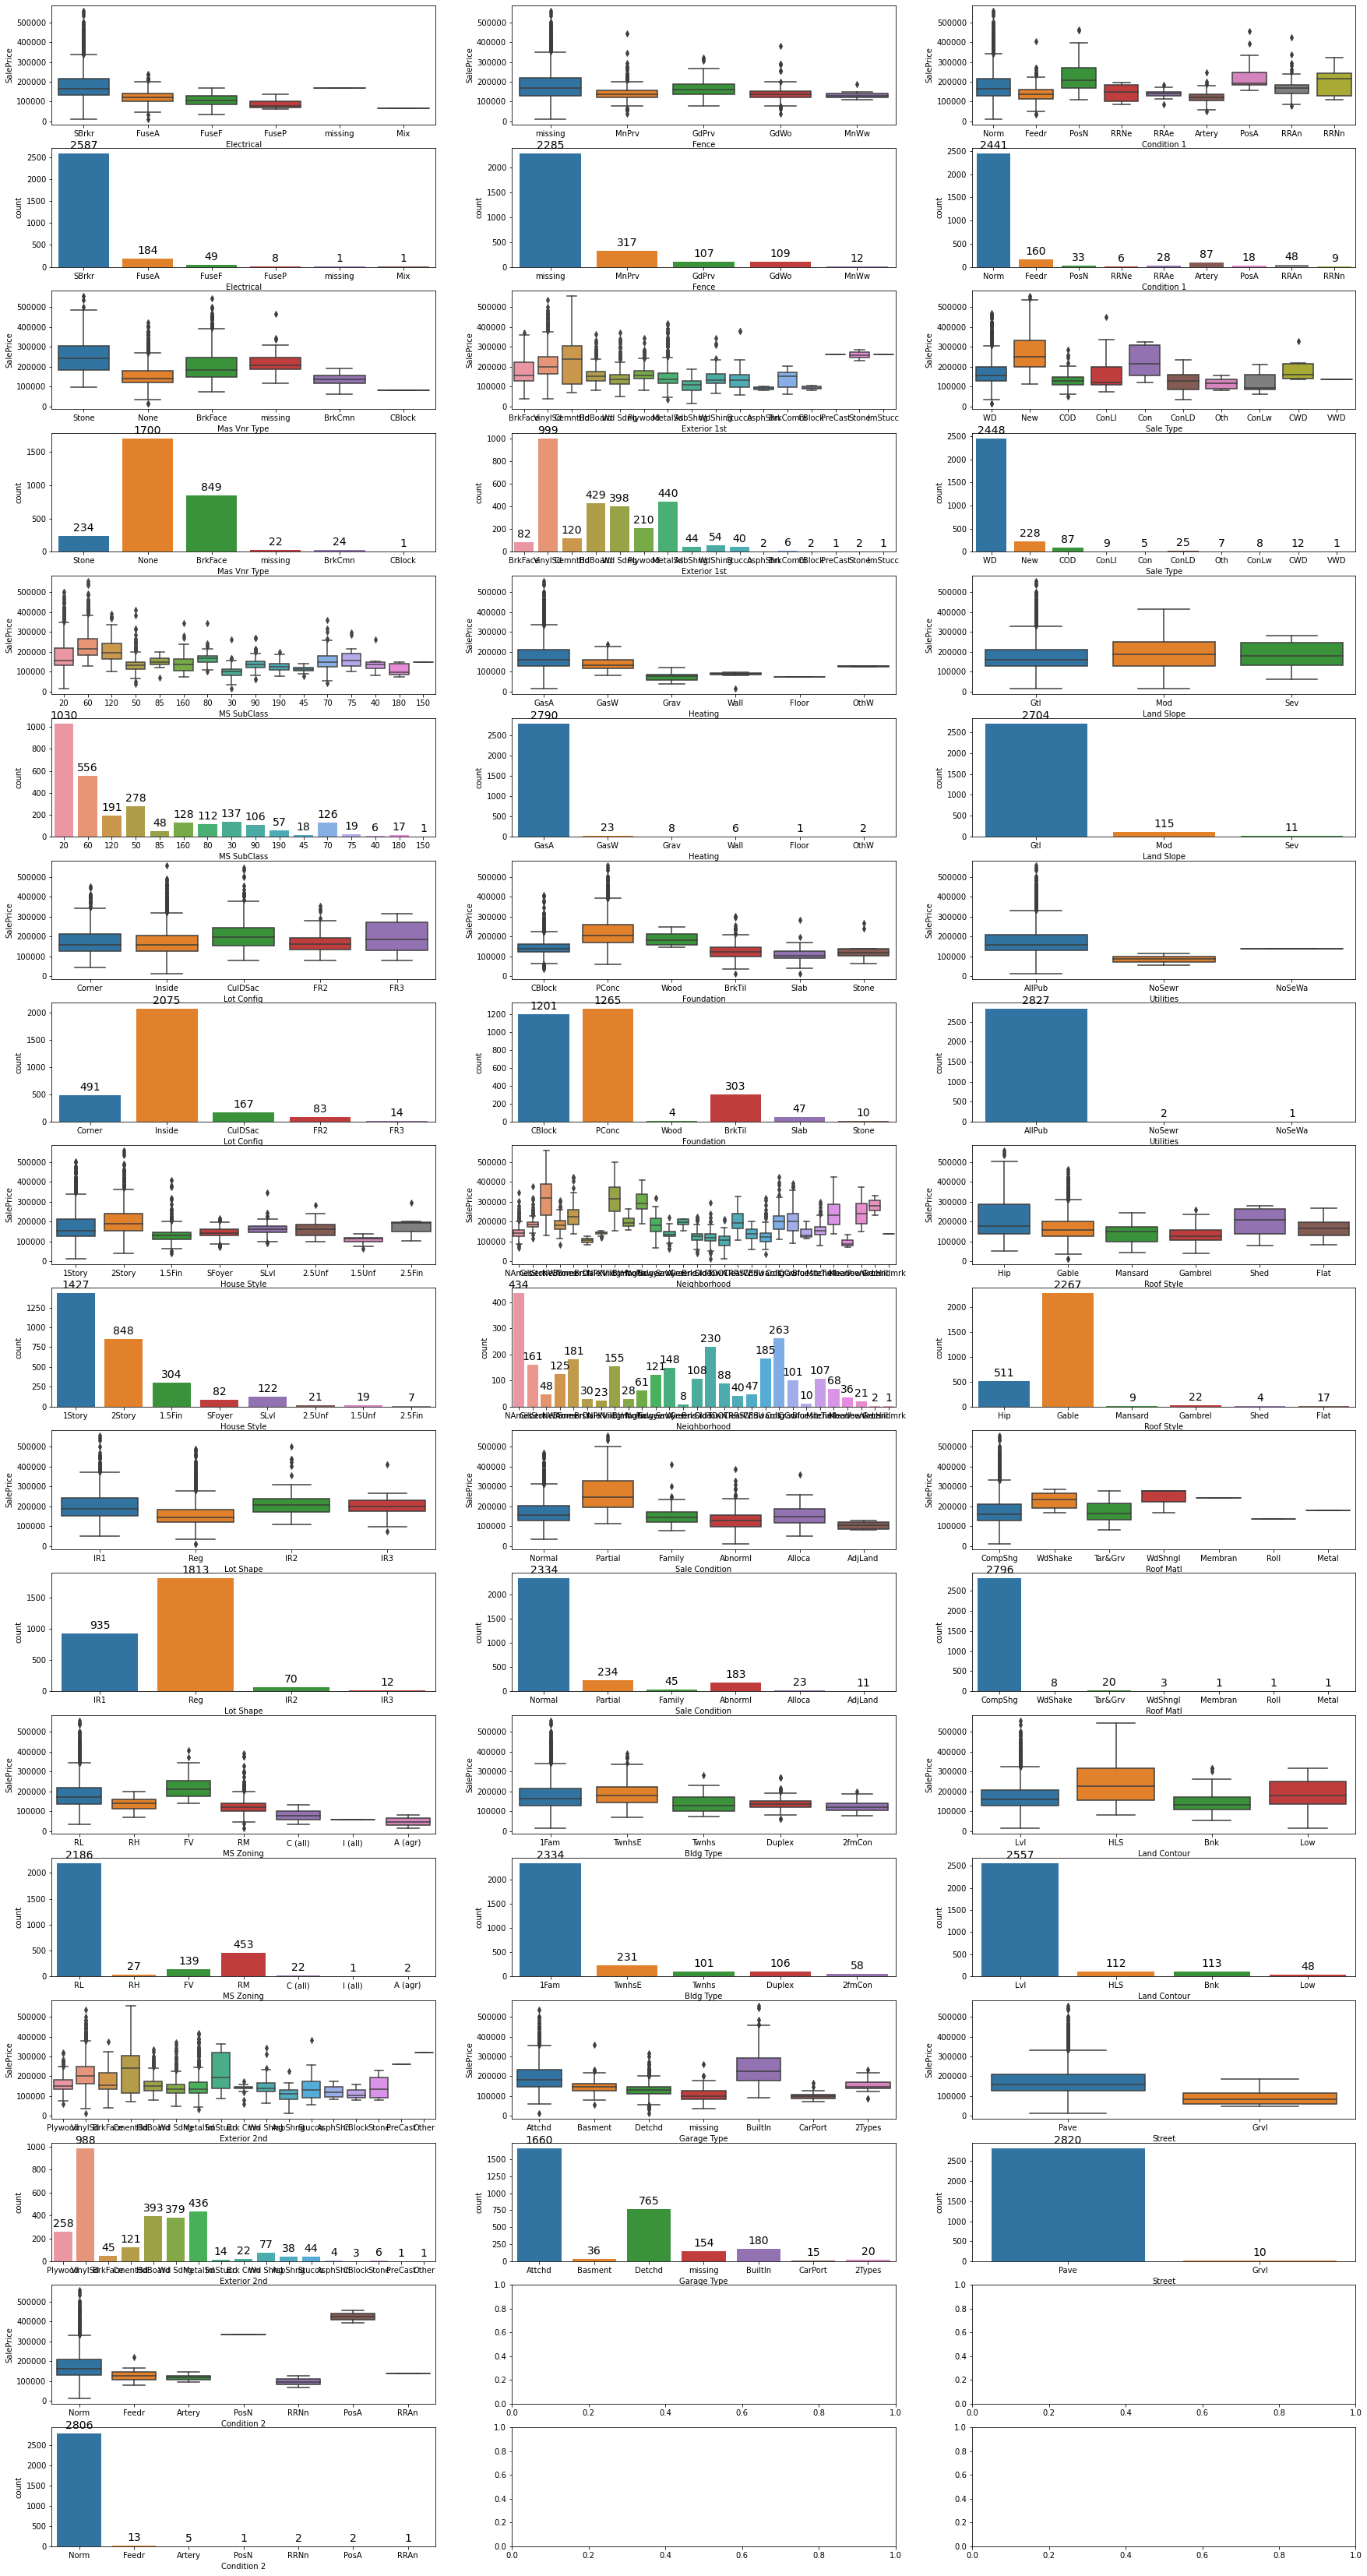

In [47]:
x = len(other_cat_feats)//3
y = 3
fig, axs = plt.subplots(2*(x+1), y, figsize=(30,60))

for idx, col in enumerate(other_cat_feats):
    #axs[2*(idx//3), idx%3].set_title(col)
    boxplot_ax, countplot_ax = axs[2*(idx//3), idx%3], axs[2*(idx//3)+1, idx%3]
    sns.boxplot(x=col, y='SalePrice', data=cat_feats, ax=boxplot_ax);
    sns.countplot(x=col, data=cat_feats, ax=countplot_ax);
    for p in countplot_ax.patches:
        countplot_ax.annotate(f'\n{p.get_height()}', 
                              xy=(p.get_x()+p.get_width()/2, p.get_height()),
                              xytext=(0,3),
                              textcoords='offset points',
                              ha='center', va='bottom', 
                              size=14)
#plt.subplots_adjust(bottom=0.2, right=0.8, top=0.8)

We immediately observe redundant features 'Roof Matl', 'Heating', 'Utilities', 'Condition 2', 'Street' are not very informative so we drop'em.

In [48]:
almost_constant_features = ['Roof Matl', 'Heating', 'Utilities', 'Condition 2', 'Street']
cat_feats.drop(almost_constant_features, axis=1, inplace=True)
other_cat_feats = other_cat_feats - set(almost_constant_features)

Also let's group values in various features based on their meaning

In [49]:
grouping_dicts = {
    'Condition 1' : {'Feedr' : 'Street', 
                     'Artery' : 'Street',
                     'PosN' : 'Pos',
                     'PosA' : 'Pos',
                     'RRNn' : 'RRn',
                     'RRAn' : 'RRn',
                     'RRNe' : 'RRe',
                     'RRAe' : 'RRe'},
    'Lot Shape' : {'IR1' : 'IR', 
                   'IR2' : 'IR', 
                   'IR3' : 'IR'},
    'Land Slope' : {'Mod' : 'Yes',
                    'Sev' : 'Yes', 
                    'Gtl' : 'No'},
    'Garage Type' : {'CarPort' : 'Other', 
                     '2Types' : 'Other', 
                     'Basment' : 'Other',
                     'missing' : 'Other'},
    'Lot Config' : {'FR2' : 'FR', 
                    'FR3' : 'FR'},
    'House Style' : {'SFoyer' : 'Sep',
                     'SLvl' : 'Sep'}
}
for col in grouping_dicts.keys():
    cat_feats[col] = cat_feats[col].apply(lambda x: grouping_dicts[col].get(x, x))

Let's inspect relationship between 'Garage Type' and 'Garage Area'

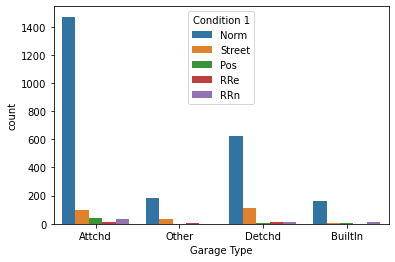

In [50]:
sns.countplot(x='Garage Type', hue='Condition 1', data=cat_feats);

Sadly enough, there's no connection between these two variables that means we cannot simplify anything

To reduce number of categories in each feature, let's transform rare values to one single category - 'Other'. For the threshold let's take 1%

In [51]:
for idx, col in enumerate(other_cat_feats):
    freqs = cat_feats[col].value_counts(normalize=True)
    mapping = cat_feats[col].map(freqs)
    cat_feats[col] = cat_feats[col].mask(mapping<0.01, 'Other')

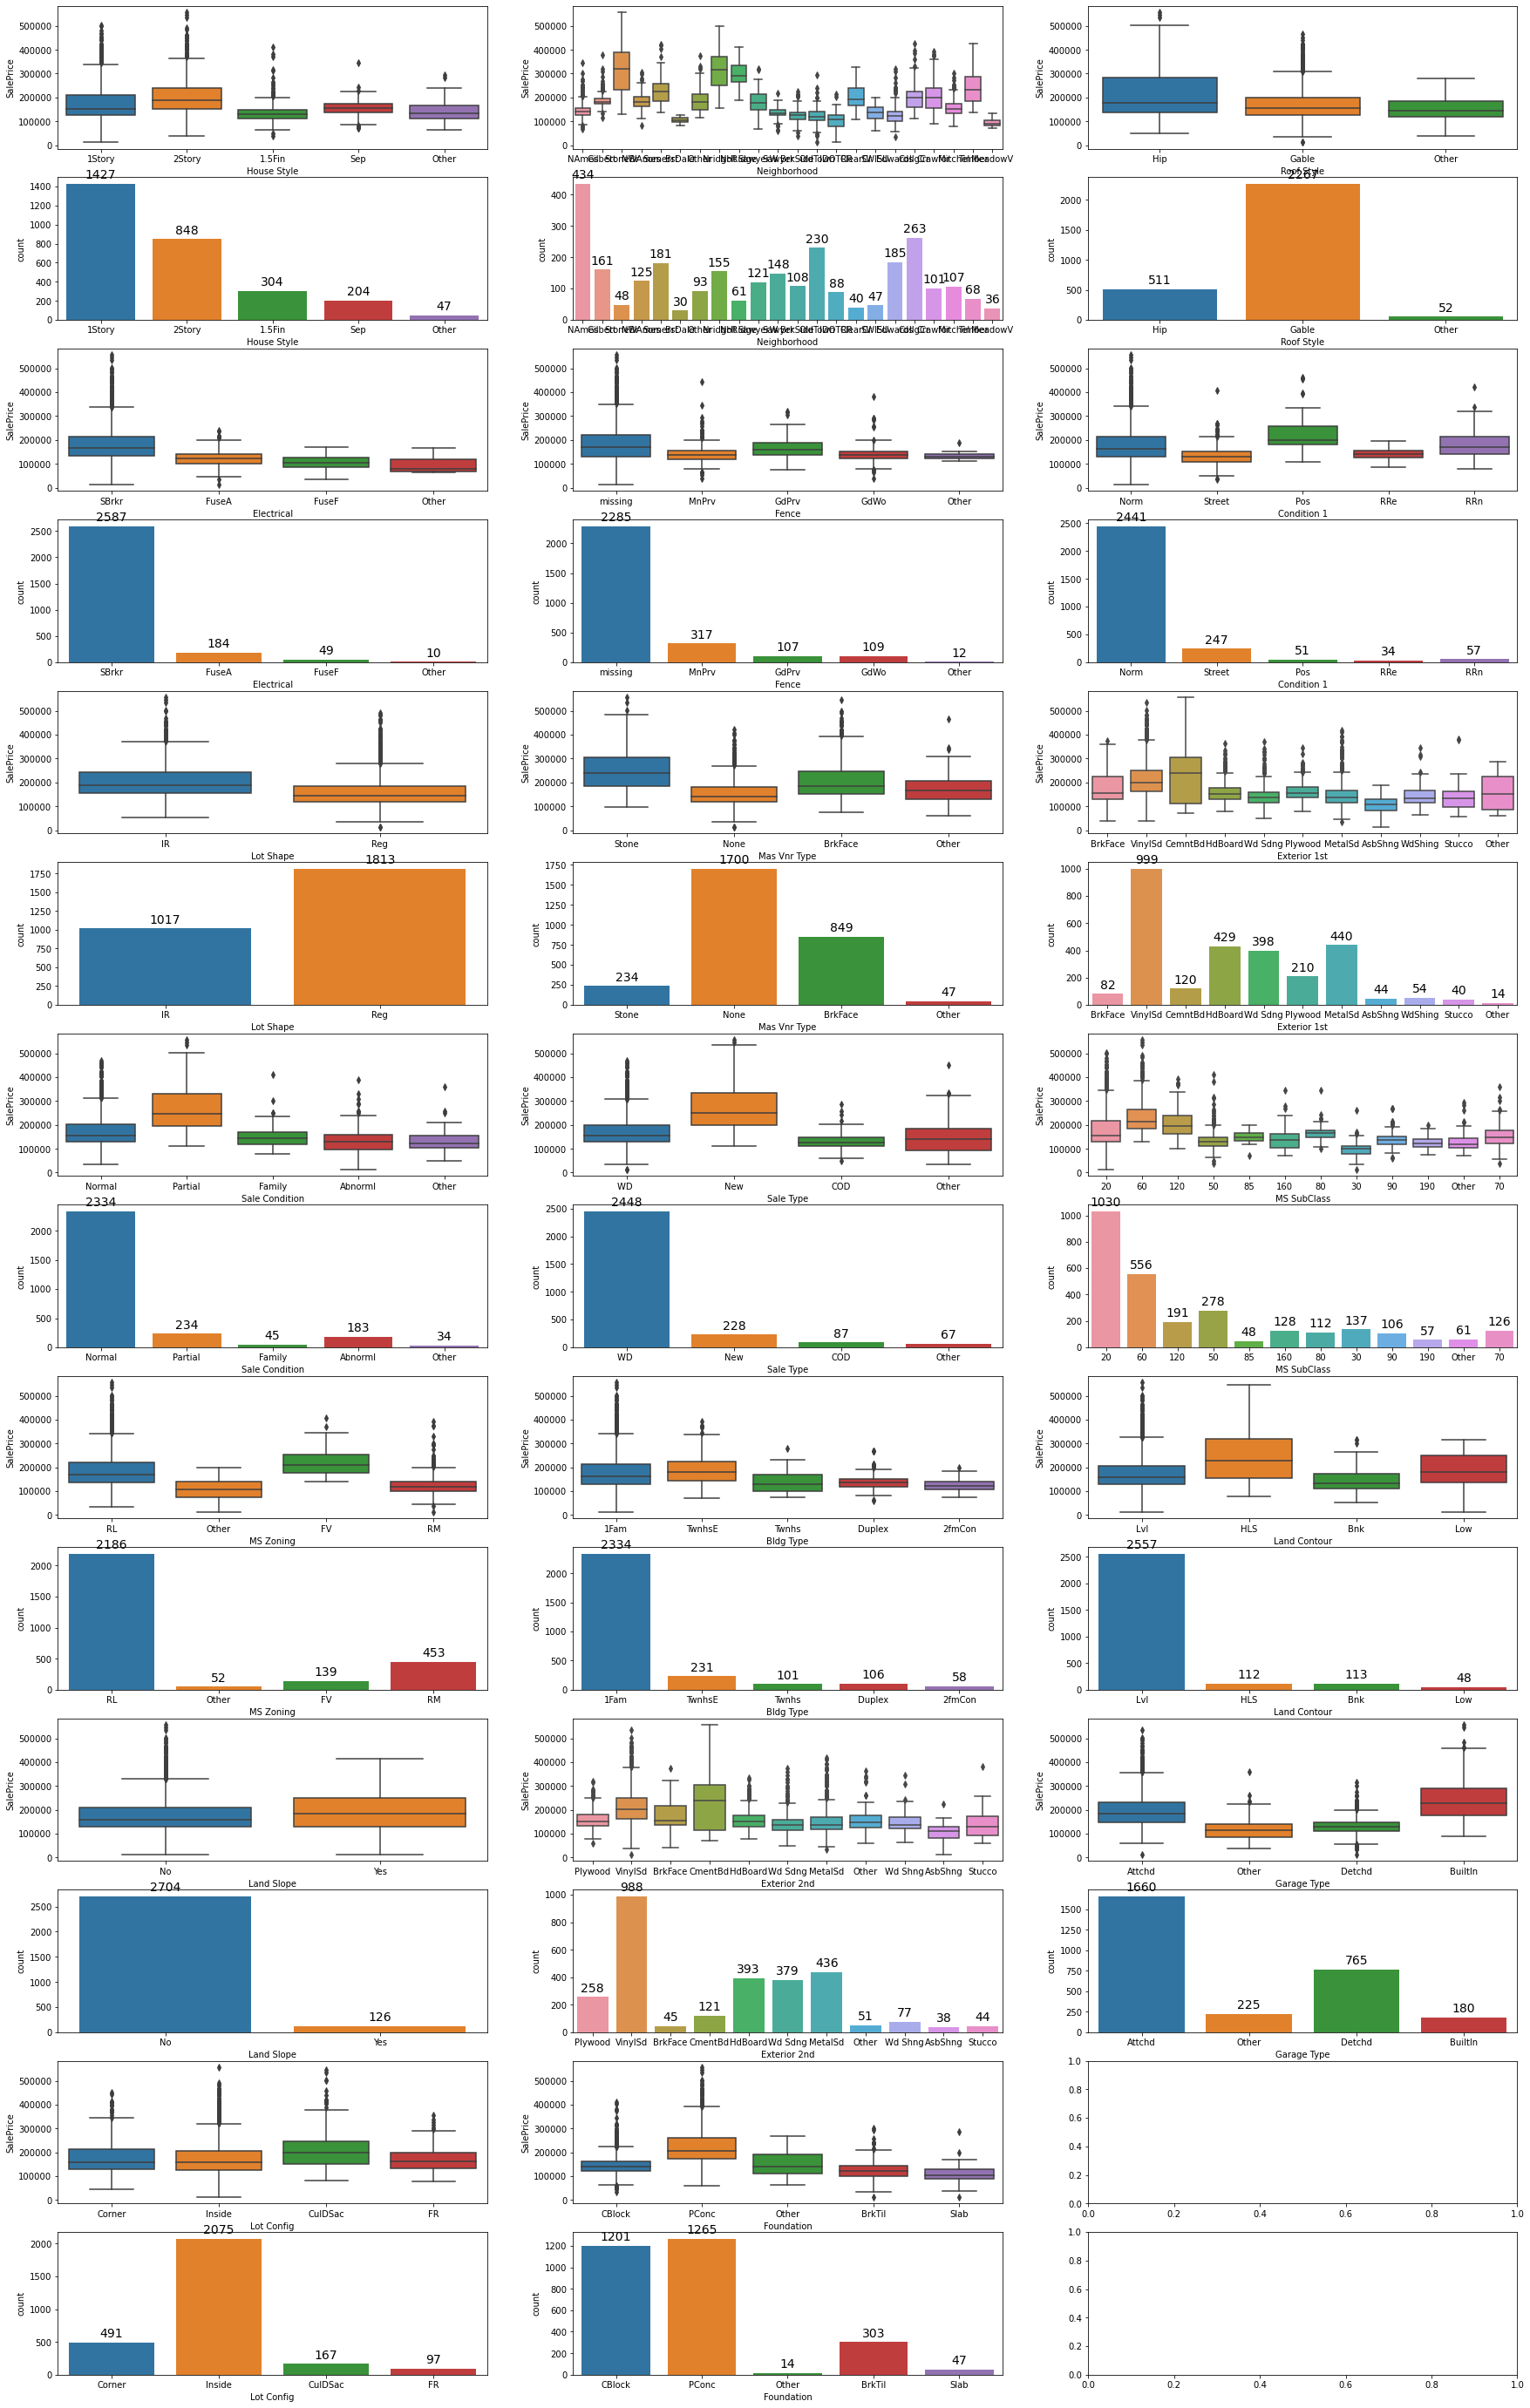

In [52]:
x = len(other_cat_feats)//3
y = 3
fig, axs = plt.subplots(2*(x+1), y, figsize=(30,50))

for idx, col in enumerate(other_cat_feats):
    #axs[2*(idx//3), idx%3].set_title(col)
    boxplot_ax, countplot_ax = axs[2*(idx//3), idx%3], axs[2*(idx//3)+1, idx%3]
    sns.boxplot(x=col, y='SalePrice', data=cat_feats, ax=boxplot_ax);
    sns.countplot(x=col, data=cat_feats, ax=countplot_ax);
    for p in countplot_ax.patches:
        countplot_ax.annotate(f'\n{p.get_height()}', 
                              xy=(p.get_x()+p.get_width()/2, p.get_height()),
                              xytext=(0,3),
                              textcoords='offset points',
                              ha='center', va='bottom', 
                              size=14)

Still, there are too many features with too many values to dummify them all. Let's look at them once again from practical point of view.
1. For sale type, let's introduce binary variable 'is_new'
2. For 'Electrical', let's make new dummy 'is_SBrkr'
3. Since we already have feature 'Mas Vnr Area', for 'Mas Vnr Type', let's make dummy 'has_stone_mas_vnr'
4. For 'Sale Condition', we could've made dummy 'is_partial', but from the description of the dataset follows that this dummy would be the same as 'is_new' so we should probably just drop it then, to avoid correlation
5. Feature 'Fence', from the looks of it, should not make much difference so we drop it

In [53]:
cat_feats['is_new'] = (cat_feats['Sale Type'] == 'New').astype('int32')
cat_feats['is_SBrkr'] = (cat_feats['Electrical'] == 'SBrkr').astype('int32')
cat_feats['has_stone_mas_vnr'] = (cat_feats['Mas Vnr Type'] == 'Stone').astype('int32')

cat_feats['lot_is_regular'] = (cat_feats['Lot Shape'] == 'Reg').astype('int32')
cat_feats['has_slope'] = (cat_feats['Land Slope'] == 'Yes').astype('int32')


In [54]:
features_to_drop = ['Fence', 'Sale Type', 'Electrical', 
                'Mas Vnr Type', 'Sale Condition',
                'Lot Shape', 'Land Slope']
cat_feats.drop(features_to_drop, axis=1, inplace=True)
other_cat_feats = other_cat_feats - set(features_to_drop)

Let's draw join distribution of 'Exterior 1st' and 'Exterior 2nd'

<AxesSubplot:xlabel='Exterior 1st', ylabel='count'>

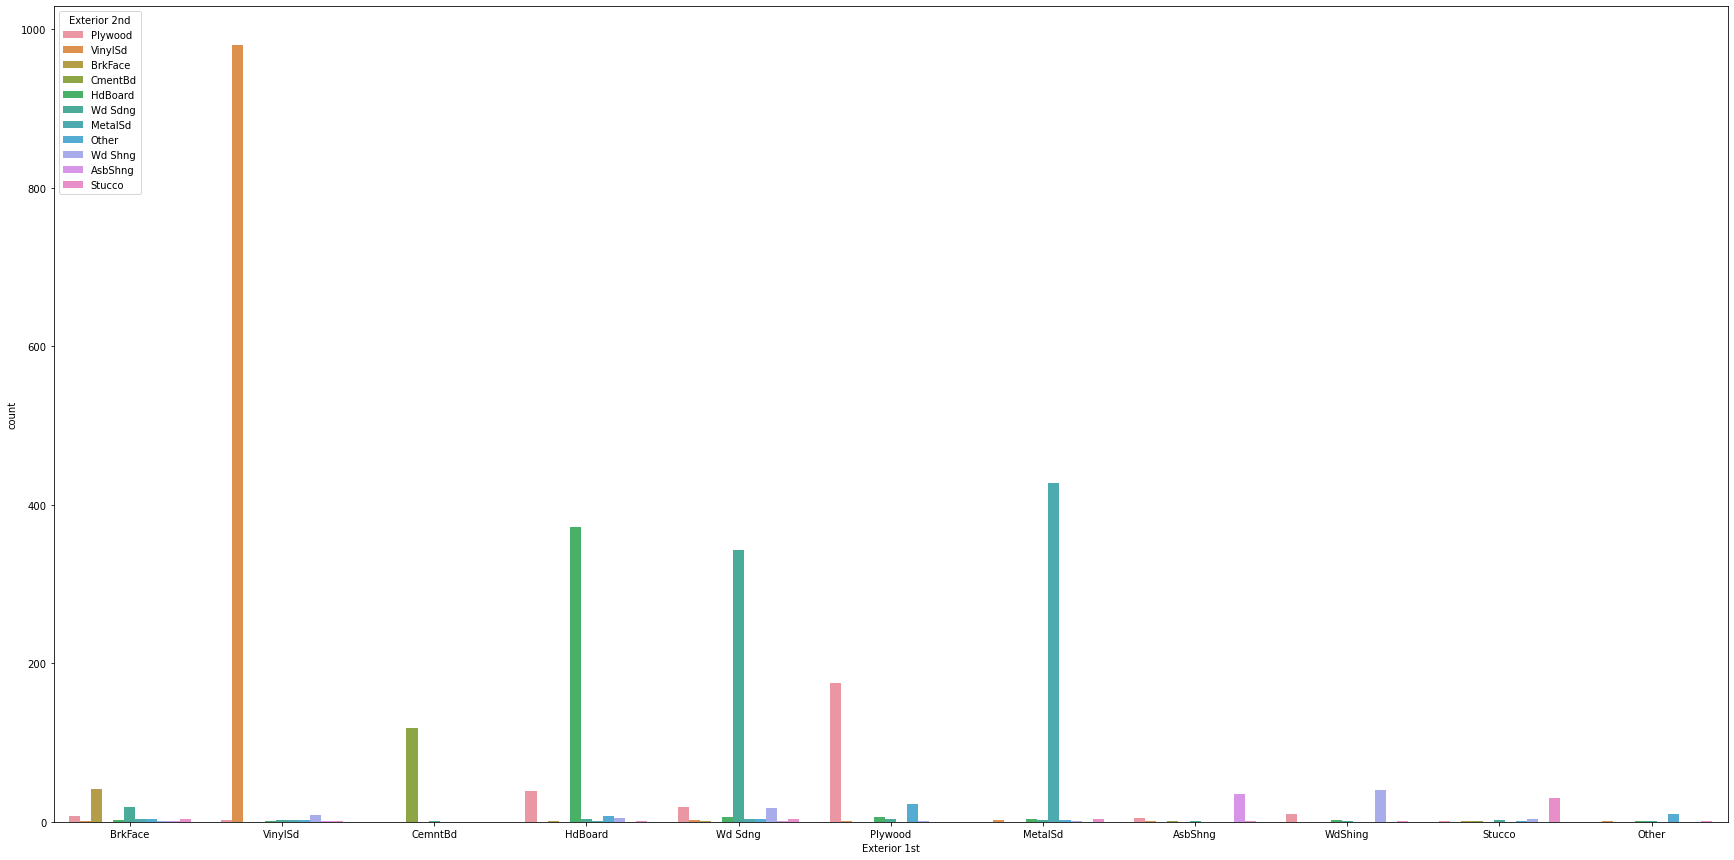

In [55]:
fig, ax = plt.subplots(figsize=(30, 15))

sns.countplot(x='Exterior 1st', hue='Exterior 2nd', data=cat_feats, ax=ax)

In [56]:
(cat_feats['Exterior 1st'] == cat_feats['Exterior 2nd']).sum()

2414

We can see that in most cases they are identical, so we will take this opportunity to drop another feature

In [57]:
cat_feats.drop('Exterior 2nd', axis=1, inplace=True)
other_cat_feats.remove('Exterior 2nd')

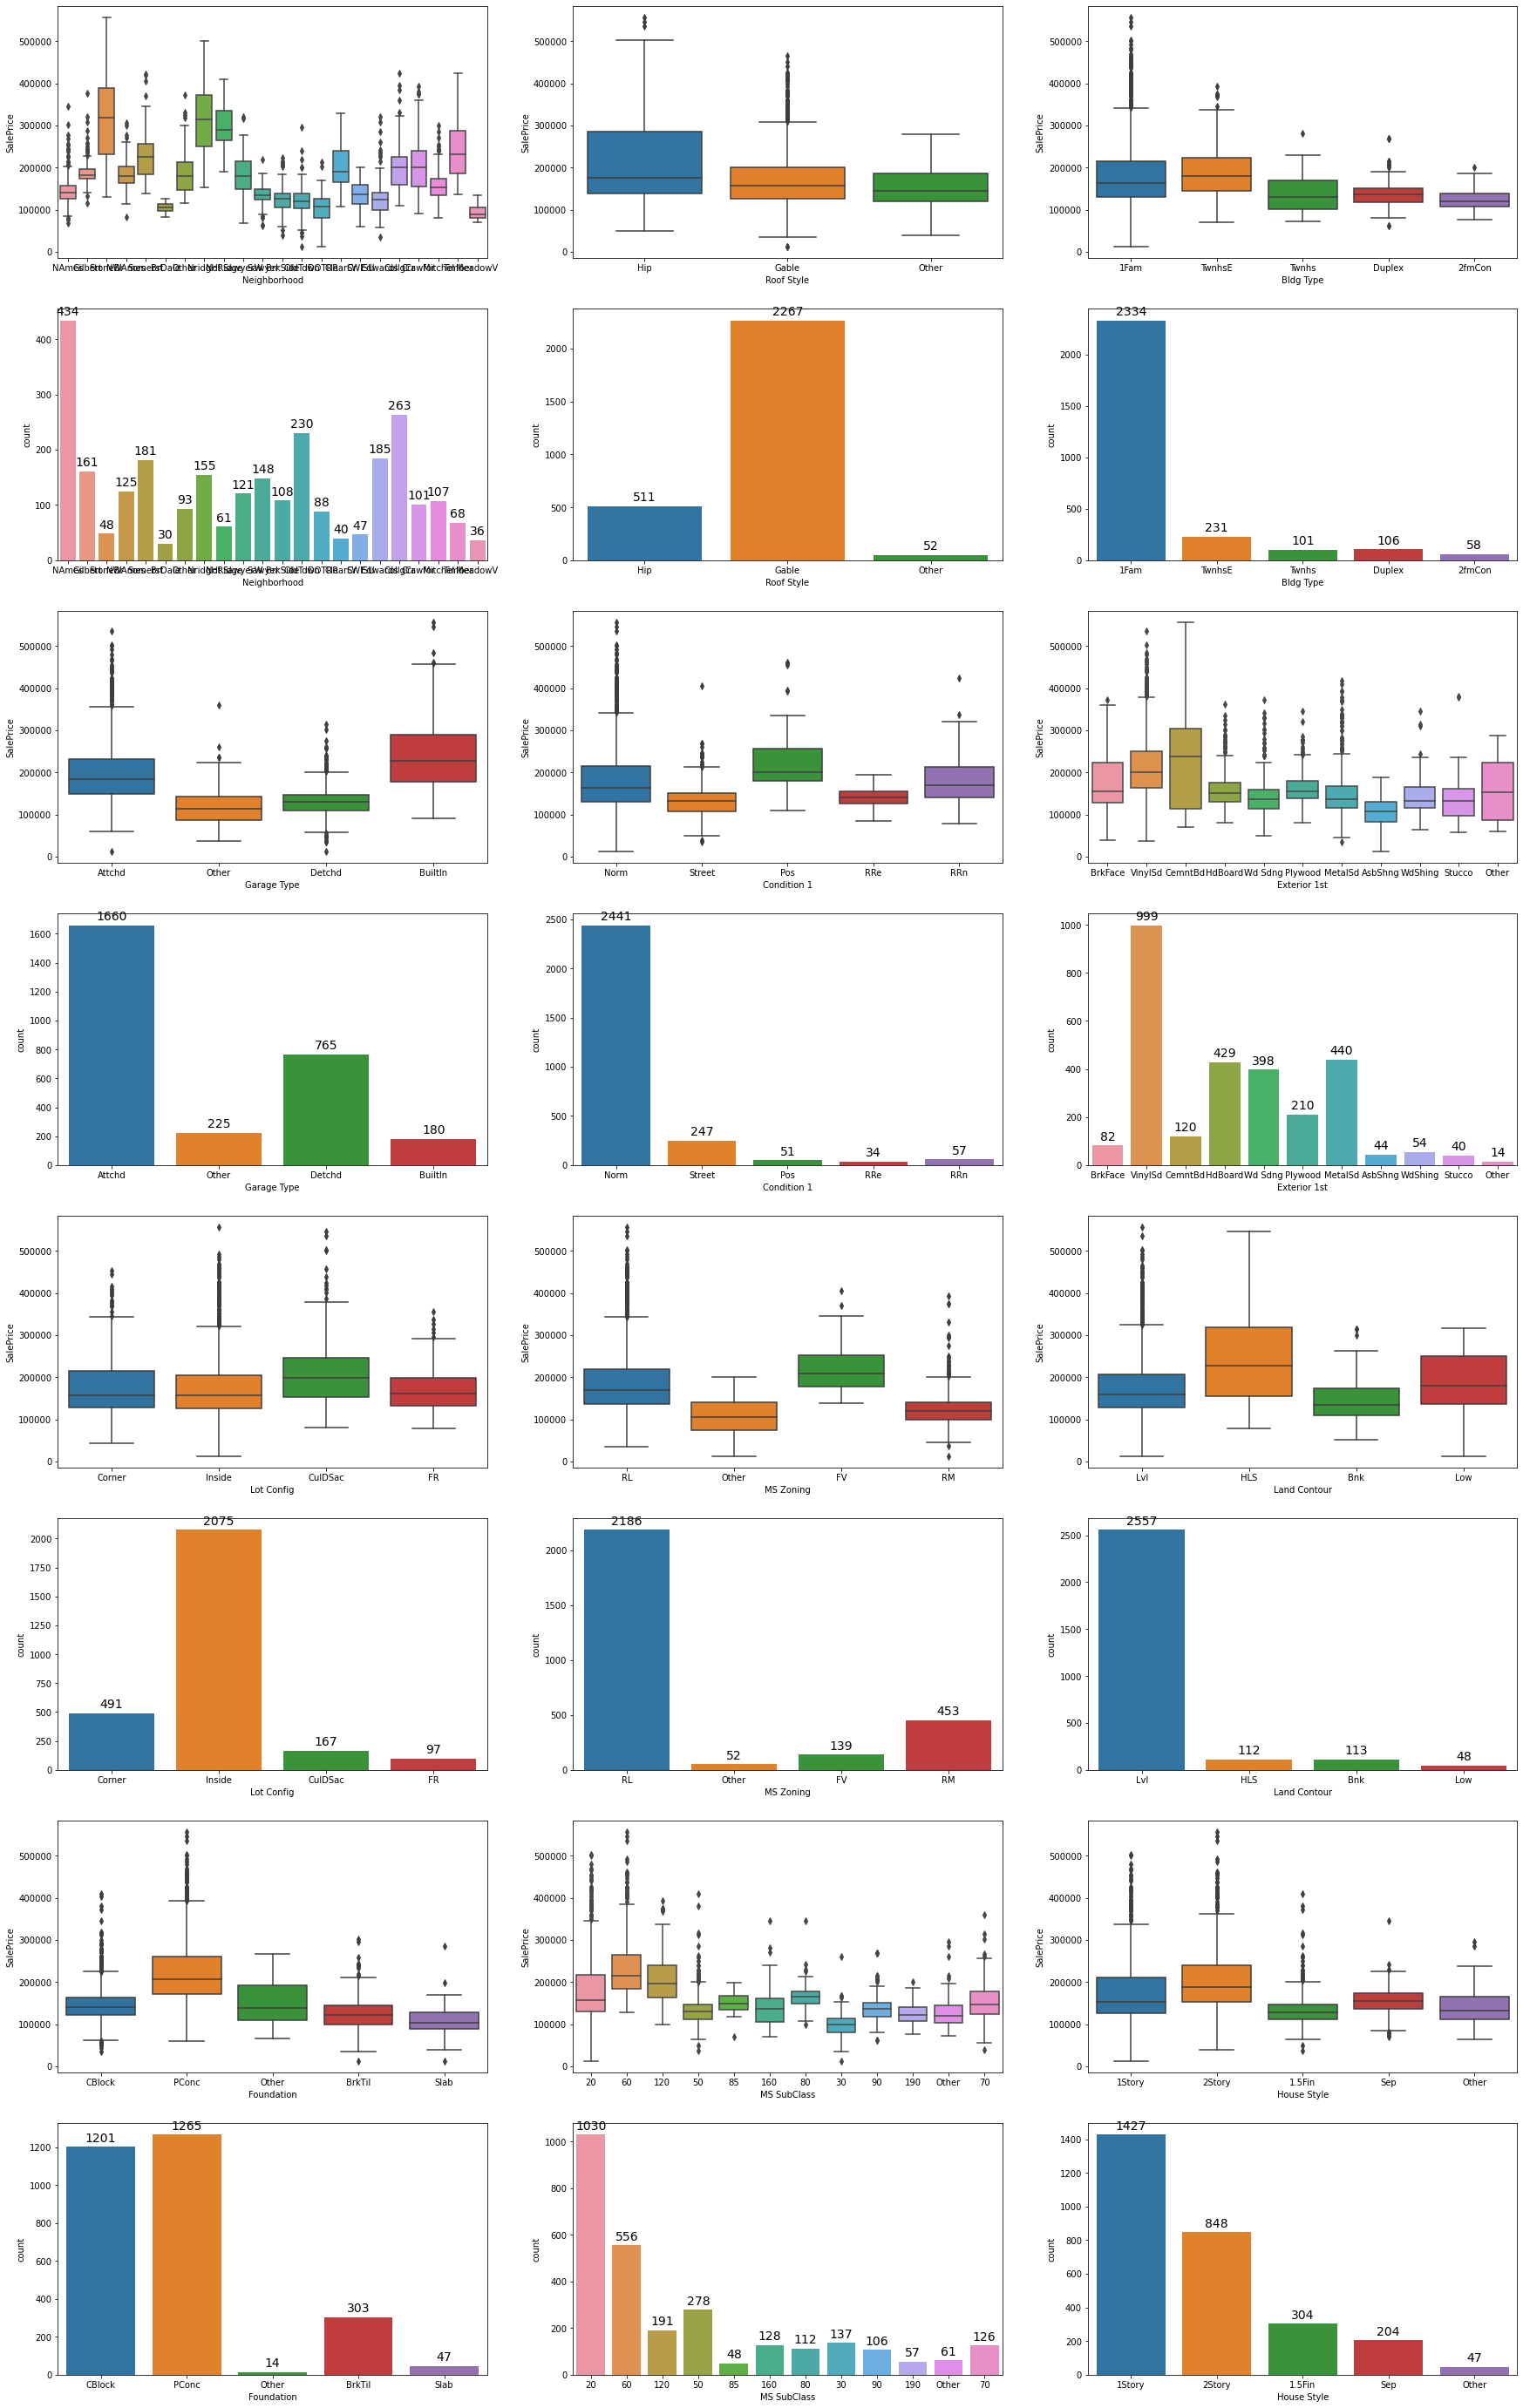

In [58]:
x = len(other_cat_feats)//3
y = 3
fig, axs = plt.subplots(2*(x), y, figsize=(30,50))

for idx, col in enumerate(other_cat_feats):
    #axs[2*(idx//3), idx%3].set_title(col)
    boxplot_ax, countplot_ax = axs[2*(idx//3), idx%3], axs[2*(idx//3)+1, idx%3]
    sns.boxplot(x=col, y='SalePrice', data=cat_feats, ax=boxplot_ax);
    sns.countplot(x=col, data=cat_feats, ax=countplot_ax);
    for p in countplot_ax.patches:
        countplot_ax.annotate(f'\n{p.get_height()}', 
                              xy=(p.get_x()+p.get_width()/2, p.get_height()),
                              xytext=(0,3),
                              textcoords='offset points',
                              ha='center', va='bottom', 
                              size=14)

For everything that still remains, we will make dummies

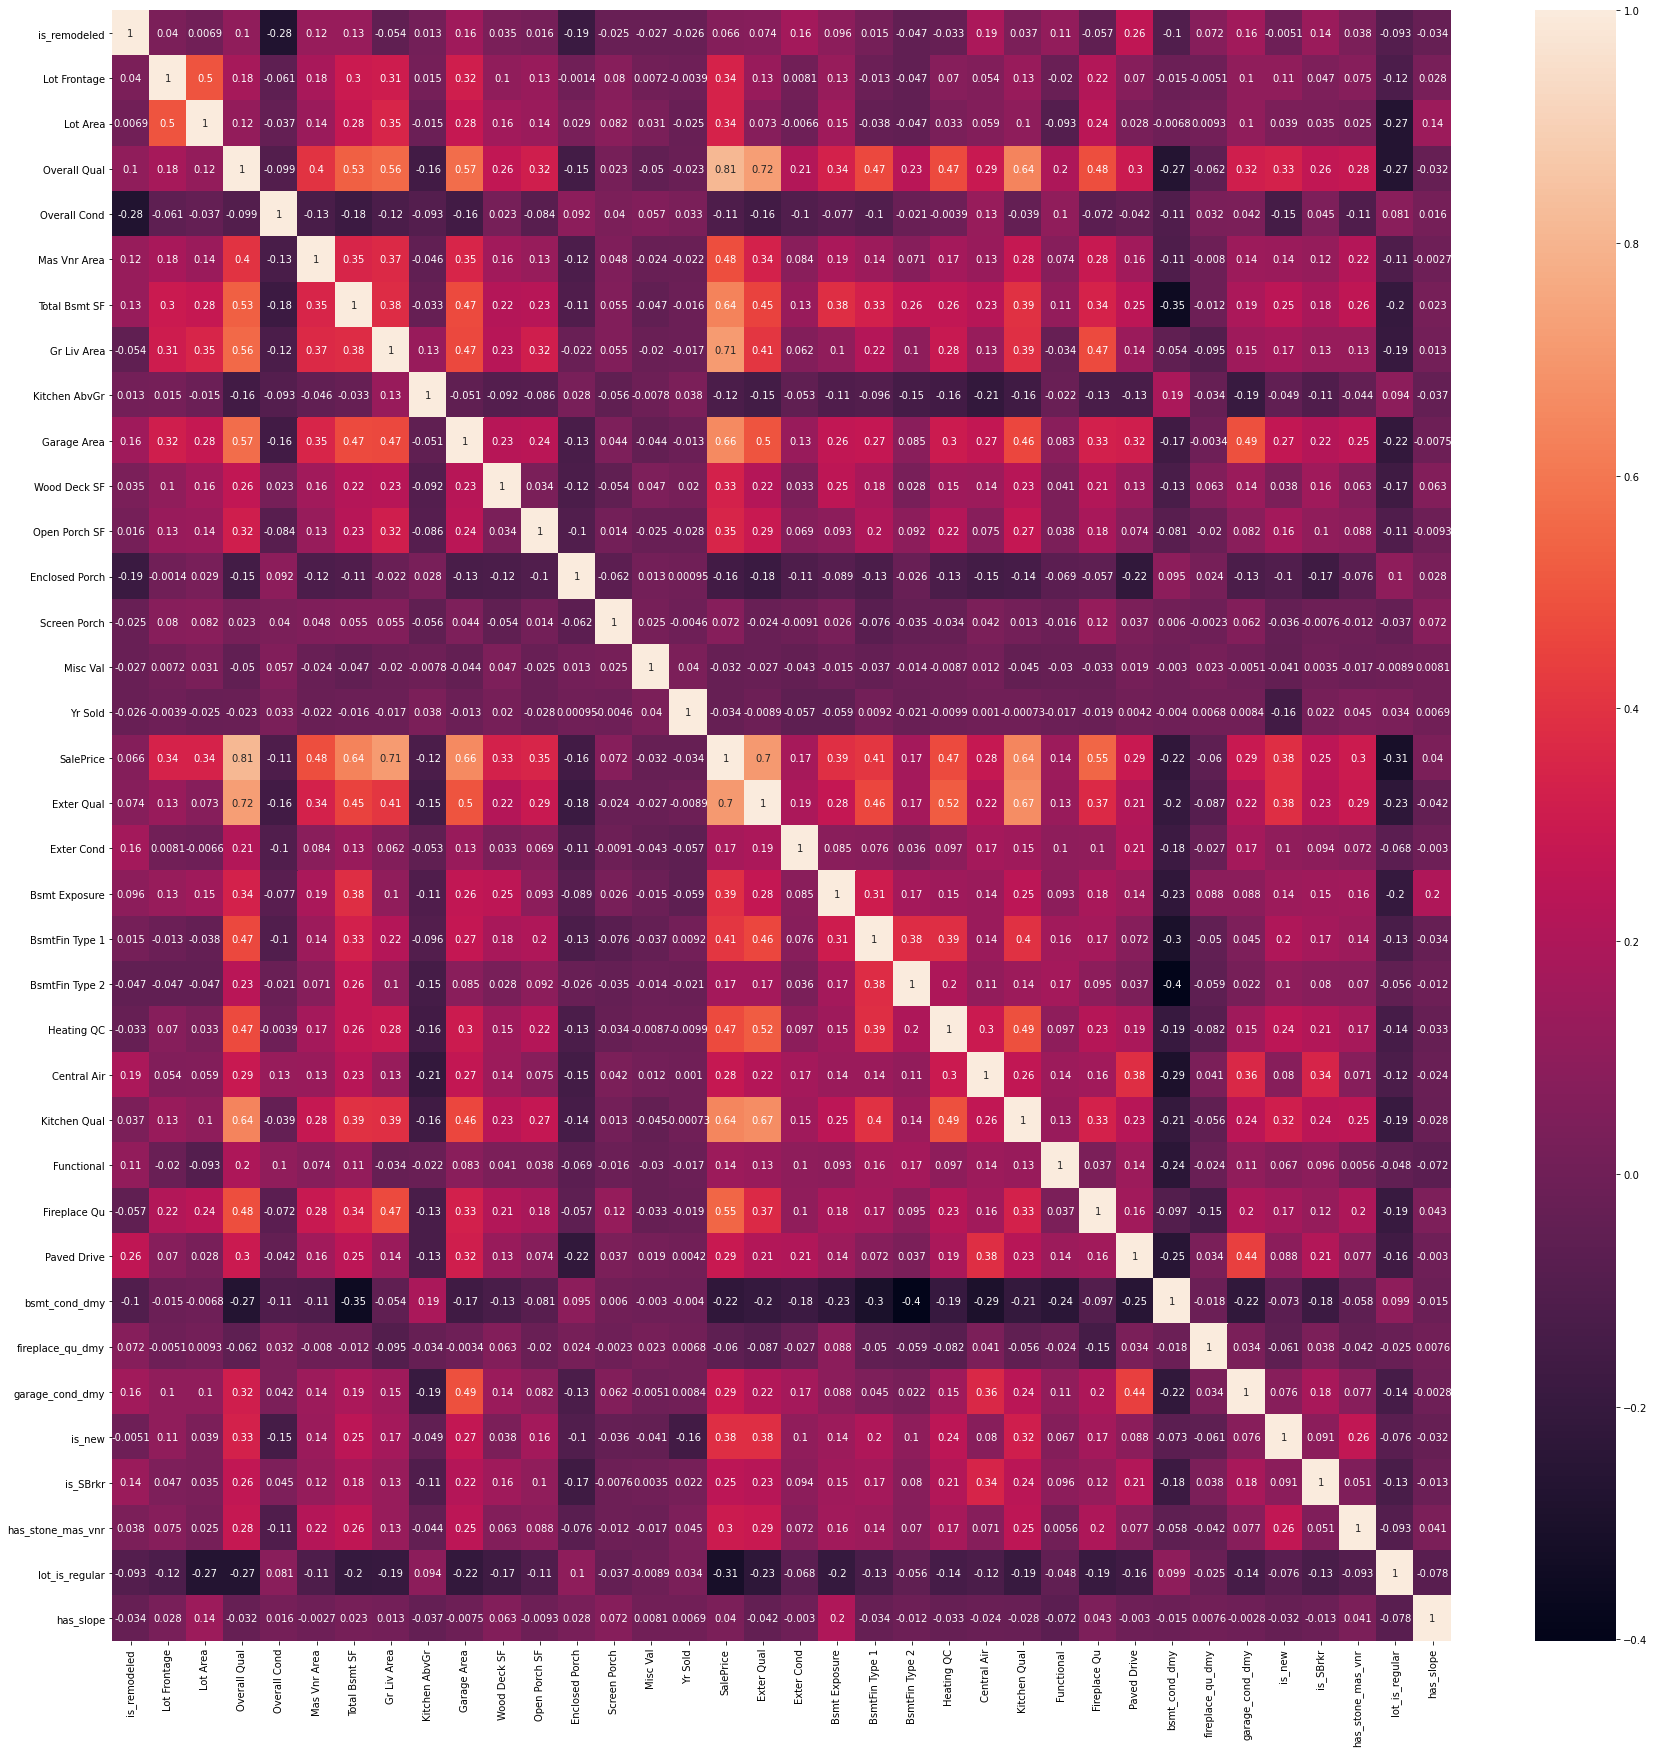

In [59]:
fig, ax = plt.subplots(figsize=(30, 30))

x = sns.heatmap(pd.concat([num_feats, cat_feats.iloc[:, 1:]], axis=1).corr(), 
                ax=ax, annot=True)

We've done everything we can... almost. Last step is to make dummies.

In [60]:
merged_data = pd.concat([num_feats, cat_feats.iloc[:, 1:]], axis=1)

In [61]:
merged_data.shape

(2830, 48)

In [62]:
prefixes = {
    'Bldg Type' : 'bldg_type',
    'Condition 1' : 'condition',
    'Exterior 1st' : 'exterior',
    'Foundation' : 'foundation',
    'Garage Type' : 'garage_type',
    'House Style' : 'house_style',
    'Land Contour' : 'land_contour',
    'Lot Config' : 'lot_config',
    'MS SubClass' : 'ms_subclass',
    'MS Zoning' : 'ms_zoning',
    'Neighborhood' : 'neighbourhood',
    'Roof Style' : 'roof_style'
}
final_data = pd.get_dummies(merged_data, columns=other_cat_feats, prefix=prefixes)

In [63]:
final_data.shape

(2830, 120)

Let's make PCA on cluster of features having high correlation ratios between them

In [64]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6)

features = ['Overall Qual', 'Exter Qual', 'Kitchen Qual',
          'Total Bsmt SF', 'Gr Liv Area', 'Garage Area']

X = final_data[features].values
X_reduced = pca.fit_transform(X)
X_frame = pd.DataFrame(X_reduced, columns=['comp_1', 'comp_2', 'comp_3', 'comp_4', 'comp_5', 'comp_6'])
pca_df = pd.concat([X_frame, final_data.reset_index().iloc[:, 1]], axis=1)

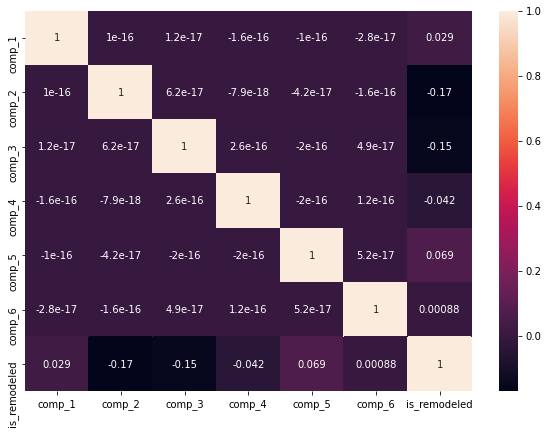

In [65]:
fig, ax = plt.subplots(figsize=(10, 7))

x = sns.heatmap(pca_df.iloc[:, :36].corr(), 
                ax=ax, annot=True)

We see that it's best to leave first four components

In [66]:
final_data = pd.concat([final_data.reset_index().iloc[:, 1:], X_frame.iloc[:, :4]], axis=1). \
    drop(features, axis=1)

In [67]:
final_data

is_remodeled  Lot Frontage  Lot Area  Overall Cond  Mas Vnr Area  \
0                1    141.000000     31770             5         112.0   
1                1     80.000000     11622             6           0.0   
2                1     93.000000     11160             5           0.0   
3                0     74.000000     13830             5           0.0   
4                1     78.000000      9978             6          20.0   
...            ...           ...       ...           ...           ...   
2825             1     37.000000      7937             6           0.0   
2826             1     68.253174      8885             5           0.0   
2827             1     62.000000     10441             5           0.0   
2828             0     77.000000     10010             5           0.0   
2829             0     74.000000      9627             5          94.0   

      Kitchen AbvGr  Wood Deck SF  Open Porch SF  Enclosed Porch  \
0                 1           210             62               0   
1                 1           140              0               0   
2                 1             0              0               0   
3                 1           212             34               0   
4                 1           360             36               0   
...             ...           ...            ...             ...   
2825              1           120              0               0   
2826              1           164              0               0   
2827              1            80             32               0   
2828              1           240             38               0   
2829              1           190             48               0   

      Screen Porch  ...  ms_subclass_Other  house_style_1.5Fin  \
0                0  ...                  0                   0   
1              120  ...                  0                   0   
2                0  ...                  0                   0   
3                0  ...                  0                   0   
4                0  ...                  0                   0   
...            ...  ...                ...                 ...   
2825             0  ...                  0                   0   
2826             0  ...                  0                   0   
2827             0  ...                  0                   0   
2828             0  ...                  0                   0   
2829             0  ...                  0                   0   

      house_style_1Story  house_style_2Story  house_style_Other  \
0                      1                   0                  0   
1                      1                   0                  0   
2                      1                   0                  0   
3                      0                   1                  0   
4                      0                   1                  0   
...                  ...                 ...                ...   
2825                   0                   0                  0   
2826                   1                   0                  0   
2827                   0                   0                  0   
2828                   1                   0                  0   
2829                   0                   1                  0   

      house_style_Sep       comp_1      comp_2      comp_3    comp_4  
0                   0   183.503924   61.539782  -23.917194  0.720688  
1                   0  -483.481481 -235.922553 -376.415966  1.098480  
2                   0  1113.849357 -506.837471  256.189723  0.342638  
3                   0    66.815888  172.121948  -13.674432  1.311376  
4                   0    42.883648  160.030189   -6.332920  0.008899  
...               ...          ...         ...         ...       ...  
2825                1  -365.418817 -261.204250 -198.438674  0.122762  
2826                0  -547.902808 -200.100001 -140.954083  0.519501  
2827                1  -583.695377 -164.357742  347.537859 -0.4